### Read: This Notebook provides model implimentation and its performance on Brown module of Mitochondrial Disease. Performance on other modules can also be viewed by replacing the gene and gene-links datasets of respective modules. Transcriptomic data will be same for all the modules.
### Points to be noted while using other modules: <br> - set threshold for confidence score for gene links in cell-13 as mentioned in Edge Score Threshold column of Table1 <br> - responsible genes are not identified for other modules except blue and brown <br> - remove selecting 20 high score edges part , cell 22, 23, 24. It is only useful for brown module <br> - change weight given for loss function while training the model. Weight will be [1/number of 0's, 1/number of 1's] in the final training set. <br>


####     <center>  Table1: Mitochondrial disease modules' overview </center>
<table style='font-size:12pt;font-style:Arial;'>
    <tr><th style='text-align:center'>Module</th><th style='text-align:center'>Pathogenic</th><th style='text-align:center'>Non-Pathogenic</th><th style='text-align:center'>Unlabeled</th><th style='text-align:center'>Total</th><th style='text-align:center'>Edge Score Threshold</th><th style='text-align:center'>Edges</th></tr>
    <tr><td style='text-align:center'>Black</td><td style='text-align:center'>15</td><td style='text-align:center'>28</td><td style='text-align:center'>209</td><td style='text-align:center'>252</td><td style='text-align:center'>>=0.5</td><td style='text-align:center'>406</td></tr>
    <tr><td style='text-align:center'>Blue</td><td style='text-align:center'>43</td><td style='text-align:center'>10</td><td style='text-align:center'>1603</td><td style='text-align:center'>1656</td><td style='text-align:center'>>=0.75</td><td style='text-align:center'>10893</td></tr>
    <tr><td style='text-align:center'>Brown</td><td style='text-align:center'>47</td><td style='text-align:center'>22</td><td style='text-align:center'>1418</td><td style='text-align:center'>1487</td><td style='text-align:center'>>=0.5</td><td style='text-align:center'>6364</td></tr>
    <tr><td style='text-align:center'>Cyan</td><td style='text-align:center'>1</td><td style='text-align:center'>9</td><td style='text-align:center'>38</td><td style='text-align:center'>48</td><td style='text-align:center'>-</td><td style='text-align:center'>43</td></tr>
    <tr><td style='text-align:center'>Green</td><td style='text-align:center'>10</td><td style='text-align:center'>20</td><td style='text-align:center'>217</td><td style='text-align:center'>247</td><td style='text-align:center'>-</td><td style='text-align:center'>436</td></tr>
    <tr><td style='text-align:center'>GreenYellow</td><td style='text-align:center'>12</td><td style='text-align:center'>3</td><td style='text-align:center'>88</td><td style='text-align:center'>103</td><td style='text-align:center'>-</td><td style='text-align:center'>209</td></tr>
    <tr><td style='text-align:center'>LightCyan</td><td style='text-align:center'>2</td><td style='text-align:center'>4</td><td style='text-align:center'>122</td><td style='text-align:center'>128</td><td style='text-align:center'>-</td><td style='text-align:center'>183</td></tr>
    <tr><td style='text-align:center'>MidnightBlue</td><td style='text-align:center'>3</td><td style='text-align:center'>55</td><td style='text-align:center'>161</td><td style='text-align:center'>219</td><td style='text-align:center'>-</td><td style='text-align:center'>319</td></tr>
    <tr><td style='text-align:center'>Salmon</td><td style='text-align:center'>9</td><td style='text-align:center'>3</td><td style='text-align:center'>55</td><td style='text-align:center'>67</td><td style='text-align:center'>-</td><td style='text-align:center'>102</td></tr>
    <tr><td style='text-align:center'>Yellow</td><td style='text-align:center'>7</td><td style='text-align:center'>8</td><td style='text-align:center'>283</td><td style='text-align:center'>298</td><td style='text-align:center'>>=0.5</td><td style='text-align:center'>482</td></tr>
    </table>

# Imports

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
from IPython.display import display

In [2]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer 
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import silhouette_score

In [3]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.classification import F1Score

from dgl.nn.pytorch import GraphConv, SAGEConv
from ray import tune

In [4]:
import warnings
warnings.filterwarnings('ignore')

####    !pip install decorator == 5.0.9         to avoid "networkx shows random_state_index is incorrect"

# Starting with the gene data

Building the graph and getting gene names, ids and if they are pathogenic or not.

In [5]:
df_brown=pd.read_csv("Data\Brown\df_brown_module.csv")

In [6]:
df_brown # non-pathogenic column : 1-pathogenic, 0=nonpathogenic, unlabelled

,GeneName,module_name,kTotal,kWithin,kOut,kDiff,is.hub,ME,MM,Mitocarta,Interactome,in_enriched_module_mitocarta,cor_with_gtex,gtex,in_md_list,pathogenic
0,SEMA3F,brown,30.545872,9.132398,21.413474,-12.281076,False,0.477729,0.374054,False,False,1,0.176808,False,False,unlabelled
1,LAP3,brown,142.383024,33.368181,109.014843,-75.646662,False,-0.695294,0.052100,True,True,1,0.178580,False,False,unlabelled
2,SLC25A5,brown,850.931187,131.143994,719.787194,-588.643200,False,-0.875225,0.000036,True,True,1,0.211125,False,False,unlabelled
3,HOXA11,brown,27.467057,6.850781,20.616276,-13.765495,False,0.317136,0.774170,False,False,1,0.158539,False,False,unlabelled
4,THSD7A,brown,14.881489,3.201778,11.679711,-8.477933,False,-0.198328,0.936240,False,False,1,0.170051,False,False,unlabelled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2388,AL590763.16,brown,30.309564,7.524000,22.785564,-15.261564,False,-0.360671,0.724569,False,False,1,0.171284,False,False,unlabelled
2389,AC011380.8,brown,36.187984,10.765991,25.421993,-14.656003,False,0.416717,0.288265,False,False,1,0.192600,False,False,unlabelled
2390,KB-1995A5.5,brown,15.120943,3.229709,11.891234,-8.661525,False,-0.213702,0.651769,False,False,1,0.182217,False,False,unlabelled
2391,LLNLR-263F3.1,brown,44.107141,12.301400,31.805741,-19.504340,False,0.409929,0.143333,False,False,1,0.183687,False,False,unlabelled


In [7]:
df_brown['pathogenic'].value_counts()

unlabelled    2314
1               49
0               30
Name: pathogenic, dtype: int64

In [8]:
df_brown[df_brown['GeneName']=='VPS13D']   

,GeneName,module_name,kTotal,kWithin,kOut,kDiff,is.hub,ME,MM,Mitocarta,Interactome,in_enriched_module_mitocarta,cor_with_gtex,gtex,in_md_list,pathogenic
62,VPS13D,brown,173.374856,47.746258,125.628599,-77.882341,False,0.198,0.860961,True,False,1,0.183256,False,False,unlabelled


In [9]:
df_brown[df_brown['GeneName']=='UFM1']   

,GeneName,module_name,kTotal,kWithin,kOut,kDiff,is.hub,ME,MM,Mitocarta,Interactome,in_enriched_module_mitocarta,cor_with_gtex,gtex,in_md_list,pathogenic
496,UFM1,brown,961.730605,88.004791,873.725814,-785.721023,False,-0.799434,0.000379,False,False,1,0.173211,False,False,unlabelled


In [10]:
df_brown[df_brown['GeneName']=='C1QBP']

,GeneName,module_name,kTotal,kWithin,kOut,kDiff,is.hub,ME,MM,Mitocarta,Interactome,in_enriched_module_mitocarta,cor_with_gtex,gtex,in_md_list,pathogenic
335,C1QBP,brown,335.23418,120.823574,214.410606,-93.587032,False,-0.951085,0.016234,True,False,1,0.194612,False,True,unlabelled


In [11]:
df_brown.dtypes

GeneName                         object
module_name                      object
kTotal                          float64
kWithin                         float64
kOut                            float64
kDiff                           float64
is.hub                             bool
ME                              float64
MM                              float64
Mitocarta                          bool
Interactome                        bool
in_enriched_module_mitocarta      int64
cor_with_gtex                   float64
gtex                               bool
in_md_list                         bool
pathogenic                       object
dtype: object

In [12]:
df_brown[df_brown.isnull().any(axis=1)]

,GeneName,module_name,kTotal,kWithin,kOut,kDiff,is.hub,ME,MM,Mitocarta,Interactome,in_enriched_module_mitocarta,cor_with_gtex,gtex,in_md_list,pathogenic


In [13]:
brown_link1=pd.read_csv("Data\Brown\gene_links_brown.csv")
#brown_link
brown_link=brown_link1[brown_link1['score']>=0.5]
brown_link

,stringId_A,stringId_B,preferredName_A,preferredName_B,ncbiTaxonId,score,nscore,fscore,pscore,ascore,escore,dscore,tscore
4,9606.ENSP00000002829,9606.ENSP00000368314,SEMA3F,NRCAM,9606,0.510,0.0,0.0,0.0,0.000,0.102,0.0,0.476
5,9606.ENSP00000002829,9606.ENSP00000263923,SEMA3F,KDR,9606,0.536,0.0,0.0,0.0,0.076,0.000,0.0,0.519
6,9606.ENSP00000002829,9606.ENSP00000356000,SEMA3F,PLXNA2,9606,0.561,0.0,0.0,0.0,0.089,0.213,0.0,0.908
7,9606.ENSP00000002829,9606.ENSP00000417335,SEMA3F,ROBO2,9606,0.618,0.0,0.0,0.0,0.052,0.000,0.0,0.613
8,9606.ENSP00000002829,9606.ENSP00000409171,SEMA3F,PLXNB2,9606,0.893,0.0,0.0,0.0,0.099,0.213,0.0,0.861
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10798,9606.ENSP00000464976,9606.ENSP00000477341,ZNF850,PPM1K,9606,0.535,0.0,0.0,0.0,0.062,0.057,0.0,0.517
10800,9606.ENSP00000466363,9606.ENSP00000479636,PIP5K1C,PLCD3,9606,0.926,0.0,0.0,0.0,0.000,0.136,0.9,0.218
10801,9606.ENSP00000467141,9606.ENSP00000470298,TTN,MYH14,9606,0.691,0.0,0.0,0.0,0.076,0.235,0.0,0.597
10802,9606.ENSP00000468348,9606.ENSP00000471493,MAP2K6,FPR1,9606,0.900,0.0,0.0,0.0,0.000,0.000,0.9,0.000


In [14]:
brown_link[(brown_link['preferredName_A']=='C1QBP')|(brown_link['preferredName_B']=='C1QBP')]

,stringId_A,stringId_B,preferredName_A,preferredName_B,ncbiTaxonId,score,nscore,fscore,pscore,ascore,escore,dscore,tscore
871,9606.ENSP00000225698,9606.ENSP00000355471,C1QBP,TFB2M,9606,0.503,0.0,0.0,0.0,0.348,0.270,0.0,0.000
872,9606.ENSP00000225698,9606.ENSP00000297185,C1QBP,HSPA9,9606,0.527,0.0,0.0,0.0,0.329,0.270,0.0,0.111
873,9606.ENSP00000225698,9606.ENSP00000254940,C1QBP,NIP7,9606,0.549,0.0,0.0,0.0,0.549,0.000,0.0,0.000
874,9606.ENSP00000225698,9606.ENSP00000419665,C1QBP,SSBP1,9606,0.549,0.0,0.0,0.0,0.434,0.000,0.0,0.235
875,9606.ENSP00000225698,9606.ENSP00000357320,C1QBP,DAP3,9606,0.553,0.0,0.0,0.0,0.281,0.354,0.0,0.113
876,9606.ENSP00000225698,9606.ENSP00000302079,C1QBP,C3AR1,9606,0.563,0.0,0.0,0.0,0.000,0.000,0.0,0.563
877,9606.ENSP00000225698,9606.ENSP00000382595,C1QBP,PAICS,9606,0.581,0.0,0.0,0.0,0.581,0.000,0.0,0.000
878,9606.ENSP00000225698,9606.ENSP00000418008,C1QBP,MRPS22,9606,0.598,0.0,0.0,0.0,0.334,0.353,0.0,0.142
879,9606.ENSP00000225698,9606.ENSP00000373620,C1QBP,HSPD1,9606,0.620,0.0,0.0,0.0,0.501,0.270,0.0,0.000
880,9606.ENSP00000225698,9606.ENSP00000478982,C1QBP,RPP38,9606,0.646,0.0,0.0,0.0,0.646,0.000,0.0,0.000


In [15]:
df_brown[df_brown['GeneName']=='VPS13D']

,GeneName,module_name,kTotal,kWithin,kOut,kDiff,is.hub,ME,MM,Mitocarta,Interactome,in_enriched_module_mitocarta,cor_with_gtex,gtex,in_md_list,pathogenic
62,VPS13D,brown,173.374856,47.746258,125.628599,-77.882341,False,0.198,0.860961,True,False,1,0.183256,False,False,unlabelled


In [16]:
gen1=['GPHN'] #brown_link  'UFM1', 'C1QBP' , 'VPS13D'
brown_link[(brown_link['preferredName_B'].isin(gen1) | brown_link['preferredName_A'].isin(gen1)) ]

,stringId_A,stringId_B,preferredName_A,preferredName_B,ncbiTaxonId,score,nscore,fscore,pscore,ascore,escore,dscore,tscore
2282,9606.ENSP00000256383,9606.ENSP00000417901,EIF2S1,GPHN,9606,0.547,0.000,0.0,0.0,0.000,0.0,0.0,0.547
5126,9606.ENSP00000287585,9606.ENSP00000417901,LHFPL4,GPHN,9606,0.723,0.000,0.0,0.0,0.000,0.0,0.0,0.723
6672,9606.ENSP00000315602,9606.ENSP00000417901,CHRNA3,GPHN,9606,0.642,0.000,0.0,0.0,0.000,0.0,0.0,0.642
7987,9606.ENSP00000344786,9606.ENSP00000417901,NFASC,GPHN,9606,0.716,0.000,0.0,0.0,0.000,0.0,0.0,0.716
8977,9606.ENSP00000358999,9606.ENSP00000417901,TMEM187,GPHN,9606,0.644,0.000,0.0,0.0,0.000,0.0,0.0,0.644
9171,9606.ENSP00000360806,9606.ENSP00000417901,KCNB1,GPHN,9606,0.643,0.000,0.0,0.0,0.000,0.0,0.0,0.643
10666,9606.ENSP00000417901,9606.ENSP00000419851,GPHN,GMPS,9606,0.534,0.158,0.0,0.0,0.062,0.0,0.0,0.458
10667,9606.ENSP00000417901,9606.ENSP00000478104,GPHN,VPS13D,9606,0.537,0.000,0.0,0.0,0.049,0.0,0.0,0.534
10668,9606.ENSP00000417901,9606.ENSP00000451648,GPHN,NRXN3,9606,0.747,0.000,0.0,0.0,0.062,0.0,0.0,0.741
10669,9606.ENSP00000417901,9606.ENSP00000457205,GPHN,C15orf59,9606,0.784,0.000,0.0,0.0,0.000,0.0,0.0,0.784


## Working with BROWN module

In [17]:
# the data that tells us if a gene is pathogenic or not
gene_data = df_brown[['GeneName','pathogenic']]
gene_data

,GeneName,pathogenic
0,SEMA3F,unlabelled
1,LAP3,unlabelled
2,SLC25A5,unlabelled
3,HOXA11,unlabelled
4,THSD7A,unlabelled
...,...,...
2388,AL590763.16,unlabelled
2389,AC011380.8,unlabelled
2390,KB-1995A5.5,unlabelled
2391,LLNLR-263F3.1,unlabelled


### keeping nodes in brown module that has connection in brown_link protein-protein intaeraction (intearction network part)

In [18]:
links_df = pd.DataFrame()
links_df[['gene1','gene2','score']]=brown_link[['preferredName_A','preferredName_B','score']]

links_df.reset_index(inplace=True,drop=True)
links_df
# read: there is an interaction between gene1 and gene2

,gene1,gene2,score
0,SEMA3F,NRCAM,0.510
1,SEMA3F,KDR,0.536
2,SEMA3F,PLXNA2,0.561
3,SEMA3F,ROBO2,0.618
4,SEMA3F,PLXNB2,0.893
...,...,...,...
7156,ZNF850,PPM1K,0.535
7157,PIP5K1C,PLCD3,0.926
7158,TTN,MYH14,0.691
7159,MAP2K6,FPR1,0.900


In [19]:
G = nx.Graph()
G.add_nodes_from([]) # number of nodes added = number of unique genes in links df that is added below.
G.add_edges_from(np.asarray(links_df[['gene1','gene2']])) # add the connections between the nodes

In [20]:
nodes_ss = list(G.nodes) # all of the genes in the graph - will be used later to filter
len(nodes_ss)

1487

In [21]:
len(list(G.edges))

7161

In [22]:
#selecting top 20 highscore edges
gene_links_r1=pd.DataFrame(columns=['gene1','gene2','score'])
for node in list(G.nodes):
    add_links=links_df[(links_df['gene1']==node)|(links_df['gene2']==node)].sort_values('score',ascending=False).head(20)
    gene_links_r1=gene_links_r1.append(add_links,ignore_index=True)

In [23]:
gene_links_r1.drop_duplicates(inplace=True)
gene_links_r1.reset_index(drop=True,inplace=True)
gene_links_r1

,gene1,gene2,score
0,SEMA3F,PLXNC1,0.973
1,SEMA3F,PLXNB1,0.949
2,SEMA3F,PLXNB2,0.893
3,SEMA3F,ROBO2,0.618
4,SEMA3F,PLXNA2,0.561
...,...,...,...
6359,GNG7,PID1,0.592
6360,CHEK2,MYO1H,0.520
6361,PNLDC1,C11orf94,0.541
6362,BTBD9,NKRF,0.654


In [24]:
#creating new network graph here from selected edges
G = nx.Graph()
G.add_nodes_from([]) # number of nodes added = number of unique genes in links df that is added below.
G.add_edges_from(np.asarray(gene_links_r1[['gene1','gene2']]))
nodes_ss=list(G.nodes)

In [25]:
len(list(G.edges))

6364

In [26]:
if 'C1QBP'in nodes_ss:  # UFM1, C1QBP, VPS13D
    print('yes')

yes


In [27]:
# filter the genes and keep only the genes that are in the graph
gene_data_ss = gene_data[gene_data['GeneName'].isin(nodes_ss)]
gene_data_ss

,GeneName,pathogenic
0,SEMA3F,unlabelled
1,LAP3,unlabelled
2,SLC25A5,unlabelled
3,HOXA11,unlabelled
4,THSD7A,unlabelled
...,...,...
2227,RASL10B,unlabelled
2288,CBSL,unlabelled
2320,HIST1H2AJ,unlabelled
2325,DACH1,unlabelled


In [28]:
gene_data_ss['pathogenic'].value_counts()    

unlabelled    1418
1               47
0               22
Name: pathogenic, dtype: int64

## Transcriptomics

In [29]:
transcriptomics=pd.read_csv('Data\Transcriptomic_data_all_color.csv')
transcriptomics

,GeneName,X10.CR.RNA,X11.WTS.RNA,X12.EA.RNA,X13.CL.RNA,X14.KD.RNA,X15.SJ.RNA,X16.HZ.RNA,X17.CE.RNA,X18.RL.RNA,...,X1.VT.RNA,X20.MCC.RNA,X2.LN.RNA,X3.AS.RNA,X4.TL.RNA,X5.BE.RNA,X6.HA.RNA,X7.HH.RNA,X8.CN.RNA,X9.GC.RNA
0,DDX11L1,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,4,0,0
1,WASH7P,34,34,26,15,42,39,27,47,26,...,26,19,36,39,44,28,42,56,79,34
2,MIR6859-1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,MIR1302-2HG,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,RP11-34P13.7,0,0,0,0,0,0,0,0,0,...,0,0,3,0,0,1,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39197,U4,0,0,1,0,0,0,0,4,0,...,0,0,4,2,1,1,1,1,0,0
39198,U6,0,0,1,0,0,0,0,0,0,...,0,0,0,0,2,1,0,0,0,0
39199,U8,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
39200,uc_338,2,1,3,1,2,1,0,0,6,...,1,7,1,1,2,5,3,0,2,0


### for interaction part

In [30]:
all_data = pd.merge(gene_data_ss, transcriptomics, left_on="GeneName", right_on="GeneName", how="inner")
all_data

,GeneName,pathogenic,X10.CR.RNA,X11.WTS.RNA,X12.EA.RNA,X13.CL.RNA,X14.KD.RNA,X15.SJ.RNA,X16.HZ.RNA,X17.CE.RNA,...,X1.VT.RNA,X20.MCC.RNA,X2.LN.RNA,X3.AS.RNA,X4.TL.RNA,X5.BE.RNA,X6.HA.RNA,X7.HH.RNA,X8.CN.RNA,X9.GC.RNA
0,SEMA3F,unlabelled,371,871,1684,209,2149,1357,655,2537,...,1084,1059,991,5938,2324,1836,861,2394,1421,759
1,LAP3,unlabelled,1134,2889,2271,2822,2704,2568,2695,2785,...,3642,2072,3616,4312,2066,1041,3097,2771,3050,2987
2,SLC25A5,unlabelled,2211,10549,5953,6986,6538,7372,7031,7529,...,10386,5789,11715,9465,4137,2373,6622,5030,8546,8686
3,HOXA11,unlabelled,500,506,949,839,769,1385,1450,1762,...,743,1314,1646,1373,487,715,184,944,292,473
4,THSD7A,unlabelled,0,5,4,7,2,5,2,2,...,1,5,2,2,4,5,0,2,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1482,RASL10B,unlabelled,70,26,124,175,335,68,126,201,...,114,144,40,228,128,104,88,86,83,72
1483,CBSL,unlabelled,1,272,0,194,143,0,64,1,...,213,215,354,0,1,1,0,0,190,189
1484,HIST1H2AJ,unlabelled,0,7,2,2,0,5,1,1,...,2,2,8,1,0,3,7,1,4,1
1485,DACH1,unlabelled,2,4,10,0,6,10,6,8,...,0,19,4,14,6,10,6,8,1,12


In [31]:
all_data_tr_weights=all_data.drop('pathogenic',axis=1)
all_data_tr_weights

,GeneName,X10.CR.RNA,X11.WTS.RNA,X12.EA.RNA,X13.CL.RNA,X14.KD.RNA,X15.SJ.RNA,X16.HZ.RNA,X17.CE.RNA,X18.RL.RNA,...,X1.VT.RNA,X20.MCC.RNA,X2.LN.RNA,X3.AS.RNA,X4.TL.RNA,X5.BE.RNA,X6.HA.RNA,X7.HH.RNA,X8.CN.RNA,X9.GC.RNA
0,SEMA3F,371,871,1684,209,2149,1357,655,2537,1048,...,1084,1059,991,5938,2324,1836,861,2394,1421,759
1,LAP3,1134,2889,2271,2822,2704,2568,2695,2785,1804,...,3642,2072,3616,4312,2066,1041,3097,2771,3050,2987
2,SLC25A5,2211,10549,5953,6986,6538,7372,7031,7529,2712,...,10386,5789,11715,9465,4137,2373,6622,5030,8546,8686
3,HOXA11,500,506,949,839,769,1385,1450,1762,579,...,743,1314,1646,1373,487,715,184,944,292,473
4,THSD7A,0,5,4,7,2,5,2,2,0,...,1,5,2,2,4,5,0,2,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1482,RASL10B,70,26,124,175,335,68,126,201,275,...,114,144,40,228,128,104,88,86,83,72
1483,CBSL,1,272,0,194,143,0,64,1,93,...,213,215,354,0,1,1,0,0,190,189
1484,HIST1H2AJ,0,7,2,2,0,5,1,1,2,...,2,2,8,1,0,3,7,1,4,1
1485,DACH1,2,4,10,0,6,10,6,8,2,...,0,19,4,14,6,10,6,8,1,12


In [32]:
# scale and transform proteomics and transcriptomics separately before merging
scaler = MinMaxScaler()
transformer = QuantileTransformer(n_quantiles=100, output_distribution='normal')

all_data.iloc[:, 2:] = scaler.fit_transform(transformer.fit_transform(all_data.iloc[:, 2:]))


## Creating the final graph with 1068 genes for intearction part

In [33]:
# we create one graph for each "weights analysis": The none, CCA, PLS, and pearson analyses
G_none = nx.subgraph(G, all_data["GeneName"])
G_cca = nx.subgraph(G, all_data["GeneName"])
G_pls = nx.subgraph(G, all_data["GeneName"])
G_pearson = nx.subgraph(G, all_data["GeneName"])

G_gini=nx.subgraph(G,all_data["GeneName"])

G_shannon=nx.subgraph(G,all_data["GeneName"])
G_renyi=nx.subgraph(G,all_data["GeneName"])
G_tsallis=nx.subgraph(G,all_data["GeneName"])
G_mutualInfo=nx.subgraph(G,all_data["GeneName"])
G_kl=nx.subgraph(G,all_data["GeneName"])
G_js=nx.subgraph(G,all_data["GeneName"])

In [34]:
# The nodes need to be labelled numerically for the DGL library, so we do this
relabel_nodes = dict((v,k) for k,v in all_data.iloc[:,0].to_dict().items())

In [35]:
G_none = nx.relabel_nodes(G_none, relabel_nodes, copy=True)
G_cca = nx.relabel_nodes(G_cca, relabel_nodes, copy=True)
G_pls = nx.relabel_nodes(G_pls, relabel_nodes, copy=True)
G_pearson = nx.relabel_nodes(G_pearson, relabel_nodes, copy=True)

G_gini=nx.relabel_nodes(G_gini,relabel_nodes,copy=True)

G_shannon=nx.relabel_nodes(G_shannon,relabel_nodes,copy=True)
G_renyi=nx.relabel_nodes(G_renyi,relabel_nodes,copy=True)
G_tsallis=nx.relabel_nodes(G_tsallis,relabel_nodes,copy=True)
G_mutualInfo=nx.relabel_nodes(G_mutualInfo,relabel_nodes,copy=True)
G_kl=nx.relabel_nodes(G_kl,relabel_nodes,copy=True)
G_js=nx.relabel_nodes(G_js,relabel_nodes,copy=True)

In [36]:
len(G_cca.nodes)

1487

In [37]:
all_data['pathogenic'].value_counts()

unlabelled    1418
1               47
0               22
Name: pathogenic, dtype: int64

# Adding weights

## Interaction part

## Canonical Correlation Analysis for weights

In [38]:
all_data_transposed = all_data_tr_weights.T
all_data_transposed.columns = all_data_transposed.iloc[0] #set row 0 as column names
all_data_transposed = all_data_transposed.drop(["GeneName"], axis=0) # remove row with pathogenic label
all_data_transposed

GeneName,SEMA3F,LAP3,SLC25A5,HOXA11,THSD7A,ACSM3,GDE1,TNFRSF12A,MAP3K9,ALDH3B1,...,FRRS1L,ZNF488,FXYD1,ZNF850,TMEM185A,RASL10B,CBSL,HIST1H2AJ,DACH1,C11orf98
X10.CR.RNA,371,1134,2211,500,0,0,2371,2769,2,1609,...,4,10,332,55,447,70,1,0,2,2
X11.WTS.RNA,871,2889,10549,506,5,9,3665,15056,14,2542,...,0,32,331,160,612,26,272,7,4,3
X12.EA.RNA,1684,2271,5953,949,4,2,3778,9997,4,4075,...,3,10,628,112,630,124,0,2,10,6
X13.CL.RNA,209,2822,6986,839,7,12,3616,15752,14,3282,...,46,38,331,97,644,175,194,2,0,5
X14.KD.RNA,2149,2704,6538,769,2,2,3734,10103,4,2918,...,2,22,771,167,719,335,143,0,6,6
X15.SJ.RNA,1357,2568,7372,1385,5,3,4911,9256,14,2785,...,4,20,93,85,748,68,0,5,10,8
X16.HZ.RNA,655,2695,7031,1450,2,5,4562,12292,6,3304,...,12,40,497,76,769,126,64,1,6,5
X17.CE.RNA,2537,2785,7529,1762,2,4,7062,11953,10,4978,...,8,8,281,92,1323,201,1,1,8,8
X18.RL.RNA,1048,1804,2712,579,0,3,3644,4918,4,2645,...,24,20,601,73,506,275,93,2,2,4
X19.DR.RNA,1800,2200,5222,916,10,2,3830,8027,2,3533,...,6,39,313,74,678,195,437,4,4,4


In [39]:
def checkIfNull(df):
    cols=[]
    for i in df.columns:
        if df[i].isnull().any():
            cols.append(i)
        else:
            continue
    if not cols:
        print("No missing values")
    else:
        print(cols)
checkIfNull(all_data)

No missing values


In [40]:
# CCA
X1 = all_data_transposed

# same scaling and transforming steps as previously
scaler = MinMaxScaler()
transformer = QuantileTransformer(n_quantiles=10, output_distribution='normal')

X1_sc = scaler.fit_transform(transformer.fit_transform(X1))

n_comp=1 #choose number of canonical variates pairs 
cca = CCA(scale=False, n_components=n_comp) #define CCA
cca.fit(X1_sc, X1_sc) #fit scaled data
X1_c, X2_c = cca.transform(X1_sc, X1_sc) #transform our datasests to obtain canonical variates

MinMaxScaler is a scaling technique that scales the values of a feature to a fixed range, typically between 0 and 1

QuantileTransformer, on the other hand, is a non-linear transformation technique that maps the data to a uniform or normal distribution

Another difference between the two is that MinMaxScaler is a parametric method that requires knowledge of the range of the data, while QuantileTransformer is a non-parametric method that does not make any assumptions about the distribution of the data.

One common use case is when the distribution of the data is not uniform and has a significant number of outliers. In this case, using MinMaxScaler alone can result in a poor scaling of the data, as it is sensitive to outliers. To address this issue, QuantileTransformer can be used to first map the data to a uniform or normal distribution before applying MinMaxScaler to scale the data to a fixed range.

Another use case is when the data has a complex, non-linear relationship between the features and the target variable. In this case, using QuantileTransformer to map the data to a uniform or normal distribution can help to capture these non-linear relationships more effectively. After mapping the data, MinMaxScaler can be used to scale the data to a fixed range.

In summary, using both MinMaxScaler and QuantileTransformer together can help to address issues related to non-uniform data distributions and outliers, as well as capture complex non-linear relationships between the features and the target variable.

In [41]:
# get analysis results into correlation df
coef_df = pd.DataFrame(np.round(cca.coef_, 6), columns = [X1.columns])
coef_df.index = X1.columns
coef_df

GeneName,SEMA3F,LAP3,SLC25A5,HOXA11,THSD7A,ACSM3,GDE1,TNFRSF12A,MAP3K9,ALDH3B1,...,FRRS1L,ZNF488,FXYD1,ZNF850,TMEM185A,RASL10B,CBSL,HIST1H2AJ,DACH1,C11orf98
GeneName,,,,,,,,,,,,,,,,,,,,,
SEMA3F,0.011873,0.004274,0.001179,0.002607,0.002563,-0.003819,0.004803,0.004729,-0.006783,0.007263,...,0.004252,-0.003020,0.001516,0.003423,0.003660,0.002752,-0.006219,-0.001439,0.006496,-0.000516
LAP3,0.001410,0.000507,0.000140,0.000310,0.000304,-0.000453,0.000570,0.000562,-0.000805,0.000862,...,0.000505,-0.000359,0.000180,0.000406,0.000435,0.000327,-0.000739,-0.000171,0.000771,-0.000061
SLC25A5,-0.000500,-0.000180,-0.000050,-0.000110,-0.000108,0.000161,-0.000202,-0.000199,0.000286,-0.000306,...,-0.000179,0.000127,-0.000064,-0.000144,-0.000154,-0.000116,0.000262,0.000061,-0.000274,0.000022
HOXA11,0.001528,0.000550,0.000152,0.000335,0.000330,-0.000491,0.000618,0.000609,-0.000873,0.000934,...,0.000547,-0.000389,0.000195,0.000440,0.000471,0.000354,-0.000800,-0.000185,0.000836,-0.000066
THSD7A,0.005857,0.002108,0.000582,0.001286,0.001264,-0.001884,0.002370,0.002333,-0.003346,0.003583,...,0.002098,-0.001490,0.000748,0.001688,0.001806,0.001357,-0.003068,-0.000710,0.003205,-0.000254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RASL10B,0.000141,0.000051,0.000014,0.000031,0.000030,-0.000045,0.000057,0.000056,-0.000080,0.000086,...,0.000050,-0.000036,0.000018,0.000041,0.000043,0.000033,-0.000074,-0.000017,0.000077,-0.000006
CBSL,-0.004425,-0.001593,-0.000439,-0.000971,-0.000955,0.001423,-0.001790,-0.001763,0.002528,-0.002707,...,-0.001585,0.001125,-0.000565,-0.001276,-0.001364,-0.001025,0.002318,0.000536,-0.002421,0.000192
HIST1H2AJ,-0.001956,-0.000704,-0.000194,-0.000430,-0.000422,0.000629,-0.000791,-0.000779,0.001118,-0.001197,...,-0.000701,0.000498,-0.000250,-0.000564,-0.000603,-0.000453,0.001025,0.000237,-0.001070,0.000085


<AxesSubplot:xlabel='GeneName', ylabel='GeneName'>

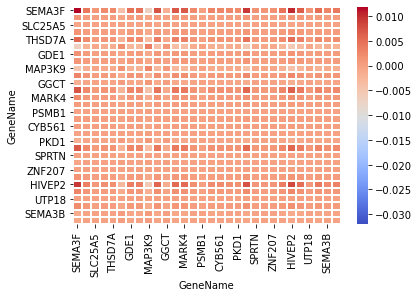

In [42]:
# check the heatmap of the first 30 genes

sns.heatmap(coef_df.iloc[0:30, 0:30], cmap='coolwarm', annot=False, linewidths=1, vmin=-0.032)

In [43]:
#transforms a DataFrame from a wide format to a long format by unpivoting the data.
def melt_and_clean(coef_df):
    # get coefficients to use as weights
    coef_df_melted = pd.melt(coef_df, id_vars=None, value_vars=None, var_name='column', value_name='value', 
                             ignore_index = False).reset_index()
    coef_df_melted = coef_df_melted.rename({"GeneName":"node1", "column":"node2", "value":"weight"}, axis=1)

    # remove duplicates
    coef_df_melted = coef_df_melted.drop_duplicates(subset=['node1', 'node2'], keep='first')
    return(coef_df_melted)

In [44]:
coef_df_melted_cca = melt_and_clean(coef_df)
coef_df_melted_cca

,node1,node2,weight
0,SEMA3F,SEMA3F,0.011873
1,LAP3,SEMA3F,0.001410
2,SLC25A5,SEMA3F,-0.000500
3,HOXA11,SEMA3F,0.001528
4,THSD7A,SEMA3F,0.005857
...,...,...,...
2211164,RASL10B,C11orf98,-0.000006
2211165,CBSL,C11orf98,0.000192
2211166,HIST1H2AJ,C11orf98,0.000085
2211167,DACH1,C11orf98,-0.000328


In [45]:
# keep only the genes that we have in our links df
cca_graph_genes = pd.merge(gene_links_r1, coef_df_melted_cca, left_on=["gene1", "gene2"], right_on=["node1", "node2"], how="inner")
cca_graph_genes = cca_graph_genes.drop(["gene1", "gene2","score"], axis=1)
cca_graph_genes

,node1,node2,weight
0,SEMA3F,PLXNC1,0.006444
1,SEMA3F,PLXNB1,0.002866
2,SEMA3F,PLXNB2,0.003754
3,SEMA3F,ROBO2,0.005918
4,SEMA3F,PLXNA2,-0.003681
...,...,...,...
6359,GNG7,PID1,-0.000467
6360,CHEK2,MYO1H,-0.000022
6361,PNLDC1,C11orf94,0.000034
6362,BTBD9,NKRF,0.000269


In [46]:
def get_graph_weights(graph_genes, neg_weights,data):
    # keep only the genes that is in the final data
    graph_genes_ = graph_genes[graph_genes['node1'].isin(data['GeneName'])]
    graph_genes_ = graph_genes_[graph_genes_["node2"].isin(data['GeneName'])]
    if neg_weights == False:
        graph_genes_["weight"] = np.abs(graph_genes_["weight"])
    return(graph_genes_)

In [47]:
def map_node_names_to_numeric(graph_genes_,data):
    # map node names to numerical node numbers for DGL
    graph_genes_['n1'] = graph_genes_['node1'].map(lambda x: data.set_index('GeneName').index.get_loc(x))
    graph_genes_['n2'] = graph_genes_['node2'].map(lambda x: data.set_index('GeneName').index.get_loc(x))
    return(graph_genes_)

In [48]:
def get_valid_edges(graph_genes, G_, data, neg_weights):
    
    graph_genes_ = get_graph_weights(graph_genes, neg_weights,data)
    graph_genes_ = map_node_names_to_numeric(graph_genes_,data) # takes a while
    #display(graph_genes_)
    
    # create a dict with a tuple of the interacting genes as the key and the weight as value - this is the format needed to add
    # it to the graph
    genes_dict = graph_genes_.iloc[:,2:].set_index(["n1", "n2"]).to_dict(orient='index') #to_dict(orient='index') -> convert the DataFrame to a dictionary with a nested structure
    
    nx.set_edge_attributes(G_, genes_dict, "name")
    # only the edges that exist in the graph now have a weight, so we need to extract these "valid" edges
    
    valid_edges = nx.get_edge_attributes(G_, "name")
    #print(valid_edges)
    # create df of valid edges
    valid_analysis_edges = pd.DataFrame.from_dict(valid_edges).T.reset_index()
    valid_analysis_edges = valid_analysis_edges.rename({'level_0': 'node1', "level_1":"node2"}, axis=1)
    return(valid_analysis_edges)

In [49]:
valid_cca_edges_neg = get_valid_edges(cca_graph_genes, G_cca, all_data, neg_weights=True)
valid_cca_edges_neg

,node1,node2,weight
0,0,620,0.006444
1,0,968,0.002866
2,0,1357,0.003754
3,0,1290,0.005918
4,0,106,-0.003681
...,...,...,...
6359,426,1249,-0.000936
6360,1249,1280,-0.000353
6361,229,431,-0.001043
6362,60,153,-0.000075


In [50]:
valid_cca_edges=get_valid_edges(cca_graph_genes, G_cca, all_data, neg_weights=False)
valid_cca_edges

,node1,node2,weight
0,0,620,0.006444
1,0,968,0.002866
2,0,1357,0.003754
3,0,1290,0.005918
4,0,106,0.003681
...,...,...,...
6359,426,1249,0.000936
6360,1249,1280,0.000353
6361,229,431,0.001043
6362,60,153,0.000075


#### Gini Index

In [51]:
gini_list=[]

In [52]:
for (gene1,gene2) in zip(gene_links_r1['gene1'],gene_links_r1['gene2']):
    expression1 = all_data_transposed[gene1]
    expression2 = all_data_transposed[gene2]
    gini_index = np.abs(expression1 - expression2).sum() / (2 * expression1.sum())
    gini_list.append([gene1, gene2, gini_index])

gini_graph_genes=pd.DataFrame(gini_list,columns=['node1','node2','weight'])
gini_graph_genes

,node1,node2,weight
0,SEMA3F,PLXNC1,0.370582
1,SEMA3F,PLXNB1,0.226745
2,SEMA3F,PLXNB2,8.406198
3,SEMA3F,ROBO2,0.404858
4,SEMA3F,PLXNA2,0.297611
...,...,...,...
6359,GNG7,PID1,3.516935
6360,CHEK2,MYO1H,0.496337
6361,PNLDC1,C11orf94,0.502793
6362,BTBD9,NKRF,0.210546


In [53]:
valid_gini_edges = get_valid_edges(gini_graph_genes, G_gini, all_data, neg_weights=False)
valid_gini_edges

,node1,node2,weight
0,0,620,0.370582
1,0,968,0.226745
2,0,1357,8.406198
3,0,1290,0.404858
4,0,106,0.297611
...,...,...,...
6359,426,1249,9.051724
6360,1249,1280,19.472473
6361,229,431,0.498218
6362,60,153,0.214126


# PLS Regression for determining weights

In [54]:
n_comp=1 
PLSR = PLSRegression(scale=False, n_components=n_comp) 
PLSR.fit(X1_sc, X1_sc) 
X1_c, X2_c = PLSR.transform(X1_sc, X1_sc) 

In [55]:
# get analysis results into correlation df
coef_df_pls = pd.DataFrame(np.round(PLSR.coef_, 6), columns = [X1.columns])
coef_df_pls.index = X1.columns
coef_df_pls

GeneName,SEMA3F,LAP3,SLC25A5,HOXA11,THSD7A,ACSM3,GDE1,TNFRSF12A,MAP3K9,ALDH3B1,...,FRRS1L,ZNF488,FXYD1,ZNF850,TMEM185A,RASL10B,CBSL,HIST1H2AJ,DACH1,C11orf98
GeneName,,,,,,,,,,,,,,,,,,,,,
SEMA3F,0.000064,0.000263,0.000294,0.000054,0.000136,0.000219,0.000250,0.000296,0.000020,0.000168,...,-0.000005,0.000123,-0.000192,0.000204,0.000238,-0.000025,-0.000025,0.000227,-0.000097,0.000371
LAP3,0.000263,0.001076,0.001204,0.000222,0.000555,0.000895,0.001022,0.001212,0.000082,0.000687,...,-0.000022,0.000505,-0.000786,0.000834,0.000976,-0.000102,-0.000102,0.000931,-0.000399,0.001520
SLC25A5,0.000294,0.001204,0.001346,0.000248,0.000620,0.001001,0.001143,0.001356,0.000092,0.000769,...,-0.000025,0.000565,-0.000879,0.000933,0.001091,-0.000114,-0.000114,0.001042,-0.000446,0.001699
HOXA11,0.000054,0.000222,0.000248,0.000046,0.000114,0.000184,0.000210,0.000250,0.000017,0.000142,...,-0.000005,0.000104,-0.000162,0.000172,0.000201,-0.000021,-0.000021,0.000192,-0.000082,0.000313
THSD7A,0.000135,0.000555,0.000620,0.000114,0.000286,0.000461,0.000527,0.000625,0.000042,0.000354,...,-0.000011,0.000260,-0.000405,0.000430,0.000503,-0.000052,-0.000052,0.000480,-0.000205,0.000783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RASL10B,-0.000025,-0.000102,-0.000114,-0.000021,-0.000052,-0.000084,-0.000096,-0.000114,-0.000008,-0.000065,...,0.000002,-0.000048,0.000074,-0.000079,-0.000092,0.000010,0.000010,-0.000088,0.000038,-0.000143
CBSL,-0.000025,-0.000102,-0.000114,-0.000021,-0.000052,-0.000085,-0.000097,-0.000115,-0.000008,-0.000065,...,0.000002,-0.000048,0.000074,-0.000079,-0.000092,0.000010,0.000010,-0.000088,0.000038,-0.000144
HIST1H2AJ,0.000227,0.000931,0.001041,0.000192,0.000480,0.000775,0.000884,0.001049,0.000071,0.000595,...,-0.000019,0.000437,-0.000680,0.000722,0.000844,-0.000088,-0.000088,0.000806,-0.000345,0.001315


<AxesSubplot:xlabel='GeneName', ylabel='GeneName'>

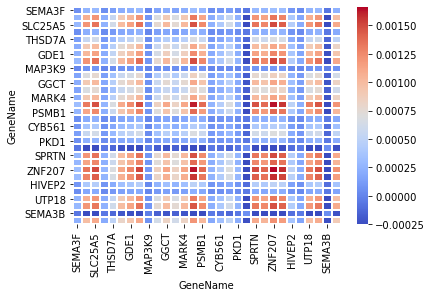

In [56]:
# check the heatmap of the first 30 genes

sns.heatmap(coef_df_pls.iloc[0:30, 0:30], cmap='coolwarm', annot=False, linewidths=1, vmin=-0.00025)

In [57]:
coef_df_melted_pls = melt_and_clean(coef_df_pls)
coef_df_melted_pls

,node1,node2,weight
0,SEMA3F,SEMA3F,0.000064
1,LAP3,SEMA3F,0.000263
2,SLC25A5,SEMA3F,0.000294
3,HOXA11,SEMA3F,0.000054
4,THSD7A,SEMA3F,0.000135
...,...,...,...
2211164,RASL10B,C11orf98,-0.000143
2211165,CBSL,C11orf98,-0.000144
2211166,HIST1H2AJ,C11orf98,0.001315
2211167,DACH1,C11orf98,-0.000563


In [58]:
# keep only the genes in the graph
pls_graph_genes = pd.merge(gene_links_r1, coef_df_melted_pls, left_on=["gene1", "gene2"], right_on=["node1", "node2"], how="inner")
pls_graph_genes = pls_graph_genes.drop(["gene1", "gene2","score"], axis=1)
pls_graph_genes

,node1,node2,weight
0,SEMA3F,PLXNC1,-0.000010
1,SEMA3F,PLXNB1,0.000062
2,SEMA3F,PLXNB2,0.000100
3,SEMA3F,ROBO2,-0.000061
4,SEMA3F,PLXNA2,0.000199
...,...,...,...
6359,GNG7,PID1,-0.000305
6360,CHEK2,MYO1H,-0.000753
6361,PNLDC1,C11orf94,0.000214
6362,BTBD9,NKRF,0.000819


In [59]:
valid_pls_edges_neg = get_valid_edges(pls_graph_genes, G_pls, all_data, neg_weights=True)
valid_pls_edges_neg

,node1,node2,weight
0,0,620,-0.000010
1,0,968,0.000062
2,0,1357,0.000100
3,0,1290,-0.000061
4,0,106,0.000199
...,...,...,...
6359,426,1249,0.000107
6360,1249,1280,-0.000000
6361,229,431,-0.000522
6362,60,153,0.000164


In [60]:
valid_pls_edges = get_valid_edges(pls_graph_genes, G_pls, all_data, neg_weights=False)
valid_pls_edges

,node1,node2,weight
0,0,620,0.000010
1,0,968,0.000062
2,0,1357,0.000100
3,0,1290,0.000061
4,0,106,0.000199
...,...,...,...
6359,426,1249,0.000107
6360,1249,1280,0.000000
6361,229,431,0.000522
6362,60,153,0.000164


# Pearson's cross correlation

In [61]:
allT=all_data_transposed.reset_index(drop=True)
s = allT.select_dtypes(include='object').columns
allT[s] = allT[s].astype("float")

corr = allT.corr(method='pearson')
corr

GeneName,SEMA3F,LAP3,SLC25A5,HOXA11,THSD7A,ACSM3,GDE1,TNFRSF12A,MAP3K9,ALDH3B1,...,FRRS1L,ZNF488,FXYD1,ZNF850,TMEM185A,RASL10B,CBSL,HIST1H2AJ,DACH1,C11orf98
GeneName,,,,,,,,,,,,,,,,,,,,,
SEMA3F,1.000000,0.375876,0.092031,0.307857,-0.012021,-0.272241,0.526947,0.178714,-0.231127,0.698466,...,0.428686,-0.382011,0.198095,0.303819,0.297749,0.401573,-0.309042,-0.270906,0.422989,-0.146212
LAP3,0.375876,1.000000,0.875786,0.259983,-0.103687,0.478838,0.655231,0.912860,0.118551,0.375660,...,0.195243,0.238003,-0.533138,0.663017,0.483323,-0.013175,0.224806,0.256094,-0.009821,0.561188
SLC25A5,0.092031,0.875786,1.000000,0.286593,0.024905,0.565115,0.545435,0.931410,0.210913,0.118460,...,-0.083184,0.447738,-0.604930,0.710908,0.462697,-0.262487,0.445119,0.458082,-0.045908,0.583182
HOXA11,0.307857,0.259983,0.286593,1.000000,-0.025833,0.007351,0.704167,0.313363,-0.209445,0.565133,...,0.081256,0.350385,-0.134520,0.039536,0.667291,0.135765,0.015829,-0.023132,0.384622,0.199978
THSD7A,-0.012021,-0.103687,0.024905,-0.025833,1.000000,-0.027219,-0.090545,0.028276,-0.211369,0.059484,...,0.019566,0.213176,-0.132796,-0.128544,-0.122256,-0.054445,0.432925,0.233846,-0.098166,-0.225115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RASL10B,0.401573,-0.013175,-0.262487,0.135765,-0.054445,-0.240265,0.200929,-0.094032,-0.229165,0.275727,...,0.414034,-0.125085,0.344575,0.110513,0.186834,1.000000,-0.051503,-0.502042,0.030378,-0.082744
CBSL,-0.309042,0.224806,0.445119,0.015829,0.432925,0.363199,-0.077879,0.374159,0.128112,-0.235136,...,-0.219732,0.768140,-0.370009,0.287190,-0.034524,-0.051503,1.000000,0.426728,-0.268972,0.181435
HIST1H2AJ,-0.270906,0.256094,0.458082,-0.023132,0.233846,0.122637,-0.014202,0.328334,-0.096678,-0.080733,...,-0.273081,0.397287,-0.344684,0.229177,0.024311,-0.502042,0.426728,1.000000,-0.166344,0.188241


In [62]:
coef_df_melted_pearson = melt_and_clean(corr)
coef_df_melted_pearson

,node1,node2,weight
0,SEMA3F,SEMA3F,1.000000
1,LAP3,SEMA3F,0.375876
2,SLC25A5,SEMA3F,0.092031
3,HOXA11,SEMA3F,0.307857
4,THSD7A,SEMA3F,-0.012021
...,...,...,...
2211164,RASL10B,C11orf98,-0.082744
2211165,CBSL,C11orf98,0.181435
2211166,HIST1H2AJ,C11orf98,0.188241
2211167,DACH1,C11orf98,-0.109433


In [63]:
# keep only the genes in the graph
pearson_graph_genes = pd.merge(gene_links_r1, coef_df_melted_pearson, left_on=["gene1", "gene2"], right_on=["node1", "node2"], 
                               how="inner")
pearson_graph_genes = pearson_graph_genes.drop(["gene1", "gene2","score"], axis=1)
pearson_graph_genes

,node1,node2,weight
0,SEMA3F,PLXNC1,0.758640
1,SEMA3F,PLXNB1,0.589128
2,SEMA3F,PLXNB2,0.494590
3,SEMA3F,ROBO2,0.184016
4,SEMA3F,PLXNA2,-0.196830
...,...,...,...
6359,GNG7,PID1,-0.356372
6360,CHEK2,MYO1H,-0.331289
6361,PNLDC1,C11orf94,-0.097008
6362,BTBD9,NKRF,0.249172


In [64]:
valid_pearson_edges_neg = get_valid_edges(pearson_graph_genes, G_pearson, all_data, neg_weights=True)
valid_pearson_edges_neg

,node1,node2,weight
0,0,620,0.758640
1,0,968,0.589128
2,0,1357,0.494590
3,0,1290,0.184016
4,0,106,-0.196830
...,...,...,...
6359,426,1249,0.021377
6360,1249,1280,0.642500
6361,229,431,-0.147029
6362,60,153,0.069051


In [65]:
valid_pearson_edges = get_valid_edges(pearson_graph_genes, G_pearson, all_data, neg_weights=False)
valid_pearson_edges

,node1,node2,weight
0,0,620,0.758640
1,0,968,0.589128
2,0,1357,0.494590
3,0,1290,0.184016
4,0,106,0.196830
...,...,...,...
6359,426,1249,0.021377
6360,1249,1280,0.642500
6361,229,431,0.147029
6362,60,153,0.069051


### Entropy

In [66]:
def joint_probabilities(expression_gene_a, expression_gene_b):
    expression_gene_a = np.array(expression_gene_a)
    expression_gene_b = np.array(expression_gene_b)
    expression_gene_a_normalized = expression_gene_a / np.sum(expression_gene_a)
    expression_gene_b_normalized = expression_gene_b / np.sum(expression_gene_b)
    # Calculate joint probabilities
    jp = expression_gene_a_normalized * expression_gene_b_normalized
    return jp

In [67]:
shannon_list=[]
for (gene1,gene2) in zip(gene_links_r1['gene1'],gene_links_r1['gene2']):
    jp = joint_probabilities(all_data_transposed[gene1],all_data_transposed[gene2])
    # Calculate entropy
    s_entropy = -np.nansum([jp[i] * np.log2(jp[i]) for i in range(len(jp))])
    shannon_list.append([gene1, gene2, s_entropy])
shannon_graph_genes=pd.DataFrame(shannon_list,columns=['node1','node2','weight'])
shannon_graph_genes

,node1,node2,weight
0,SEMA3F,PLXNC1,0.492144
1,SEMA3F,PLXNB1,0.456972
2,SEMA3F,PLXNB2,0.439530
3,SEMA3F,ROBO2,0.414042
4,SEMA3F,PLXNA2,0.388795
...,...,...,...
6359,GNG7,PID1,0.375216
6360,CHEK2,MYO1H,0.353223
6361,PNLDC1,C11orf94,0.302156
6362,BTBD9,NKRF,0.432410


In [68]:
valid_shannon_edges = get_valid_edges(shannon_graph_genes, G_shannon, all_data, neg_weights=True)
valid_shannon_edges

,node1,node2,weight
0,0,620,0.492144
1,0,968,0.456972
2,0,1357,0.439530
3,0,1290,0.414042
4,0,106,0.388795
...,...,...,...
6359,426,1249,0.390847
6360,1249,1280,0.441800
6361,229,431,0.374367
6362,60,153,0.426314


In [69]:
renyi_list=[]
alpha=2
for (gene1,gene2) in zip(gene_links_r1['gene1'],gene_links_r1['gene2']):
    jp = joint_probabilities(all_data_transposed[gene1],all_data_transposed[gene2])
    # Calculate entropy
    r_entropy = 1 / (1 - alpha) * np.log2(np.nansum(jp**alpha))
    renyi_list.append([gene1, gene2, r_entropy])
renyi_graph_genes=pd.DataFrame(renyi_list,columns=['node1','node2','weight'])
renyi_graph_genes

,node1,node2,weight
0,SEMA3F,PLXNC1,9.938038
1,SEMA3F,PLXNB1,10.997224
2,SEMA3F,PLXNB2,11.646732
3,SEMA3F,ROBO2,10.473999
4,SEMA3F,PLXNA2,12.556123
...,...,...,...
6359,GNG7,PID1,12.708330
6360,CHEK2,MYO1H,12.245130
6361,PNLDC1,C11orf94,10.762230
6362,BTBD9,NKRF,12.694943


In [70]:
valid_renyi_edges = get_valid_edges(renyi_graph_genes, G_renyi, all_data, neg_weights=True)
valid_renyi_edges

,node1,node2,weight
0,0,620,9.938038
1,0,968,10.997224
2,0,1357,11.646732
3,0,1290,10.473999
4,0,106,12.556123
...,...,...,...
6359,426,1249,11.801828
6360,1249,1280,12.373141
6361,229,431,11.719015
6362,60,153,12.651910


In [71]:
tsallis_list=[]
q=2
for (gene1,gene2) in zip(gene_links_r1['gene1'],gene_links_r1['gene2']):
    jp = joint_probabilities(all_data_transposed[gene1],all_data_transposed[gene2])
    # Calculate entropy
    t_entropy = 1 / (q - 1) * (np.nansum(jp**q) - 1)
    tsallis_list.append([gene1, gene2, t_entropy])
tsallis_graph_genes=pd.DataFrame(tsallis_list,columns=['node1','node2','weight'])
tsallis_graph_genes

,node1,node2,weight
0,SEMA3F,PLXNC1,-0.998981
1,SEMA3F,PLXNB1,-0.999511
2,SEMA3F,PLXNB2,-0.999688
3,SEMA3F,ROBO2,-0.999297
4,SEMA3F,PLXNA2,-0.999834
...,...,...,...
6359,GNG7,PID1,-0.999851
6360,CHEK2,MYO1H,-0.999794
6361,PNLDC1,C11orf94,-0.999424
6362,BTBD9,NKRF,-0.999849


In [72]:
valid_tsallis_edges = get_valid_edges(tsallis_graph_genes, G_tsallis, all_data, neg_weights=True)
valid_tsallis_edges

,node1,node2,weight
0,0,620,-0.998981
1,0,968,-0.999511
2,0,1357,-0.999688
3,0,1290,-0.999297
4,0,106,-0.999834
...,...,...,...
6359,426,1249,-0.999720
6360,1249,1280,-0.999811
6361,229,431,-0.999703
6362,60,153,-0.999845


In [73]:
mis=[]
for (gene1,gene2) in zip(gene_links_r1['gene1'],gene_links_r1['gene2']):
    mi=mutual_info_regression(all_data_transposed[gene1].values.reshape(-1, 1), all_data_transposed[gene2].values)
    mis.append([gene1,gene2,mi[0]])
    
mutualInfo_graph_genes=pd.DataFrame(mis,columns=['node1','node2','weight'])
mutualInfo_graph_genes

,node1,node2,weight
0,SEMA3F,PLXNC1,0.121193
1,SEMA3F,PLXNB1,0.112998
2,SEMA3F,PLXNB2,0.137456
3,SEMA3F,ROBO2,0.000000
4,SEMA3F,PLXNA2,0.228271
...,...,...,...
6359,GNG7,PID1,0.000000
6360,CHEK2,MYO1H,0.127198
6361,PNLDC1,C11orf94,0.000000
6362,BTBD9,NKRF,0.094493


In [74]:
valid_mutualInfo_edges = get_valid_edges(mutualInfo_graph_genes, G_mutualInfo, all_data, neg_weights=True)
valid_mutualInfo_edges

,node1,node2,weight
0,0,620,0.121193
1,0,968,0.112998
2,0,1357,0.137456
3,0,1290,0.000000
4,0,106,0.228271
...,...,...,...
6359,426,1249,0.009362
6360,1249,1280,0.299804
6361,229,431,0.093537
6362,60,153,0.004293


In [75]:

def normalize_gene_expression(expression):
    total = np.nansum(expression)
    probabilities = expression / total
    return probabilities

def calculate_kl_divergence(p, q):
    kl_divergence = np.nansum([p[i] * np.log2(p[i] / q[i]) for i in range(len(p)) if q[i]!=0])
    return kl_divergence

def calculate_js_divergence(p, q):
    m = 0.5 * (p + q)
    js_divergence = 0.5 * np.nansum([p[i] * np.log2(p[i] / m[i]) for i in range(len(p)) if m[i]!=0]) + 0.5 * np.nansum([q[i] * np.log2(q[i] / m[i]) for i in range(len(p)) if m[i]!=0])
    return js_divergence

kl = []
js = []

for (gene1, gene2) in zip(gene_links_r1['gene1'], gene_links_r1['gene2']):
    p = normalize_gene_expression(all_data_transposed[gene1].values)
    q = normalize_gene_expression(all_data_transposed[gene2].values)

    # Calculate KL divergence
    kl_divergence = calculate_kl_divergence(p, q)
    # Calculate JS divergence
    js_divergence = calculate_js_divergence(p, q)

    kl.append([gene1, gene2, kl_divergence])
    js.append([gene1, gene2, js_divergence])

kl_graph_genes = pd.DataFrame(kl, columns=['node1', 'node2', 'weight'])
js_graph_genes = pd.DataFrame(js, columns=['node1', 'node2', 'weight'])


In [76]:
kl_graph_genes

,node1,node2,weight
0,SEMA3F,PLXNC1,0.253349
1,SEMA3F,PLXNB1,0.217302
2,SEMA3F,PLXNB2,0.245556
3,SEMA3F,ROBO2,1.559194
4,SEMA3F,PLXNA2,0.573136
...,...,...,...
6359,GNG7,PID1,0.720430
6360,CHEK2,MYO1H,0.463935
6361,PNLDC1,C11orf94,2.422658
6362,BTBD9,NKRF,0.066459


In [77]:
valid_kl_edges = get_valid_edges(kl_graph_genes, G_kl, all_data, neg_weights=True)
valid_kl_edges

,node1,node2,weight
0,0,620,0.253349
1,0,968,0.217302
2,0,1357,0.245556
3,0,1290,1.559194
4,0,106,0.573136
...,...,...,...
6359,426,1249,0.920497
6360,1249,1280,0.061339
6361,229,431,0.188126
6362,60,153,0.152686


In [78]:
js_graph_genes

,node1,node2,weight
0,SEMA3F,PLXNC1,0.057225
1,SEMA3F,PLXNB1,0.057033
2,SEMA3F,PLXNB2,0.060705
3,SEMA3F,ROBO2,0.265803
4,SEMA3F,PLXNA2,0.134876
...,...,...,...
6359,GNG7,PID1,0.166666
6360,CHEK2,MYO1H,0.259665
6361,PNLDC1,C11orf94,0.479736
6362,BTBD9,NKRF,0.016105


In [79]:
valid_js_edges = get_valid_edges(js_graph_genes, G_js, all_data, neg_weights=True)
valid_js_edges

,node1,node2,weight
0,0,620,0.057225
1,0,968,0.057033
2,0,1357,0.060705
3,0,1290,0.265803
4,0,106,0.134876
...,...,...,...
6359,426,1249,0.240932
6360,1249,1280,0.015759
6361,229,431,0.240266
6362,60,153,0.038082


# Building the DGL graphs

The purpose of converting a NetworkX graph object to a DGL graph object is to be able to apply deep learning methods to the graph data. NetworkX graph object can be used in GCN, but NetworkX is not specifically designed for deep learning on graphs. 

In [80]:
def build_dgl_network(graph_weights_method, edge_df, data, weight_method):
    # Create an empty DGL graph
    G_dgl = dgl.DGLGraph()

    # Add nodes with features
    G_dgl.add_nodes(data.shape[0])
    G_dgl.ndata['feat'] = torch.from_numpy(data.iloc[:, 2:].values)
    
    src = np.array(edge_df["node1"])
    dst = np.array(edge_df["node2"])

    if weight_method != "None":
        edge_weights = np.array(edge_df["weight"])
        edge_weights = torch.tensor(edge_weights)
        G_dgl.add_edges(torch.tensor(src), torch.tensor(dst), data={'weight': edge_weights})
    else:
        G_dgl.add_edges(torch.tensor(src), torch.tensor(dst))
        

    return G_dgl


#### For absolute weights

In [81]:
G_dgl_none = build_dgl_network(G_none, valid_pearson_edges, all_data, "None") # use any edge data as placeholder - will not be added
G_dgl_none

Graph(num_nodes=1487, num_edges=6364,
      ndata_schemes={'feat': Scheme(shape=(20,), dtype=torch.float64)}
      edata_schemes={})

In [82]:
G_dgl_cca = build_dgl_network(G_cca, valid_cca_edges,all_data, "CCA")
G_dgl_cca

Graph(num_nodes=1487, num_edges=6364,
      ndata_schemes={'feat': Scheme(shape=(20,), dtype=torch.float64)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float64)})

In [83]:
G_dgl_pls = build_dgl_network(G_pls, valid_pls_edges, all_data, "PLS")
G_dgl_pls

Graph(num_nodes=1487, num_edges=6364,
      ndata_schemes={'feat': Scheme(shape=(20,), dtype=torch.float64)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float64)})

In [84]:
G_dgl_pearson = build_dgl_network(G_pearson, valid_pearson_edges, all_data, "PEARSON")
G_dgl_pearson

Graph(num_nodes=1487, num_edges=6364,
      ndata_schemes={'feat': Scheme(shape=(20,), dtype=torch.float64)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float64)})

#### For negative weights

In [85]:
G_dgl_none_neg = build_dgl_network(G_none, valid_pearson_edges_neg, all_data, "None") # use any edge data as placeholder - will not be added
G_dgl_none_neg

Graph(num_nodes=1487, num_edges=6364,
      ndata_schemes={'feat': Scheme(shape=(20,), dtype=torch.float64)}
      edata_schemes={})

In [86]:
G_dgl_cca_neg = build_dgl_network(G_cca, valid_cca_edges_neg,all_data, "CCA")
G_dgl_cca_neg

Graph(num_nodes=1487, num_edges=6364,
      ndata_schemes={'feat': Scheme(shape=(20,), dtype=torch.float64)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float64)})

In [87]:
G_dgl_pls_neg = build_dgl_network(G_pls, valid_pls_edges_neg, all_data, "PLS")
G_dgl_pls_neg

Graph(num_nodes=1487, num_edges=6364,
      ndata_schemes={'feat': Scheme(shape=(20,), dtype=torch.float64)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float64)})

In [88]:
G_dgl_pearson_neg = build_dgl_network(G_pearson, valid_pearson_edges_neg, all_data, "PEARSON")
G_dgl_pearson_neg

Graph(num_nodes=1487, num_edges=6364,
      ndata_schemes={'feat': Scheme(shape=(20,), dtype=torch.float64)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float64)})

#### for gini

In [89]:
G_dgl_gini = build_dgl_network(G_gini,valid_gini_edges,all_data,"Gini")
G_dgl_gini

Graph(num_nodes=1487, num_edges=6364,
      ndata_schemes={'feat': Scheme(shape=(20,), dtype=torch.float64)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float64)})

#### other edge weights

In [90]:
G_dgl_shannon = build_dgl_network(G_shannon,valid_shannon_edges,all_data,"Shannon")
G_dgl_shannon

Graph(num_nodes=1487, num_edges=6364,
      ndata_schemes={'feat': Scheme(shape=(20,), dtype=torch.float64)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float64)})

In [91]:
G_dgl_renyi = build_dgl_network(G_renyi,valid_renyi_edges,all_data,"Renyi")
G_dgl_renyi

Graph(num_nodes=1487, num_edges=6364,
      ndata_schemes={'feat': Scheme(shape=(20,), dtype=torch.float64)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float64)})

In [92]:
G_dgl_tsallis = build_dgl_network(G_tsallis,valid_tsallis_edges,all_data,"Tsallis")
G_dgl_tsallis

Graph(num_nodes=1487, num_edges=6364,
      ndata_schemes={'feat': Scheme(shape=(20,), dtype=torch.float64)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float64)})

In [93]:
G_dgl_mutualInfo = build_dgl_network(G_mutualInfo,valid_mutualInfo_edges,all_data,"mutualInfo")
G_dgl_mutualInfo

Graph(num_nodes=1487, num_edges=6364,
      ndata_schemes={'feat': Scheme(shape=(20,), dtype=torch.float64)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float64)})

In [94]:
G_dgl_kl = build_dgl_network(G_kl,valid_kl_edges,all_data,"KL")
G_dgl_kl

Graph(num_nodes=1487, num_edges=6364,
      ndata_schemes={'feat': Scheme(shape=(20,), dtype=torch.float64)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float64)})

In [95]:
G_dgl_js = build_dgl_network(G_js,valid_js_edges,all_data,"JS")
G_dgl_js

Graph(num_nodes=1487, num_edges=6364,
      ndata_schemes={'feat': Scheme(shape=(20,), dtype=torch.float64)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float64)})

# Building the GCN:

In [96]:
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, weight =torch.double ): 
        super(GCN, self).__init__()
        self.conv1 = SAGEConv(in_feats, hidden_size, 'pool',norm=nn.BatchNorm1d(hidden_size))
        self.conv2 = GraphConv(hidden_size, hidden_size, weight=weight) 
        self.conv3 = SAGEConv(hidden_size, hidden_size, 'pool',norm=nn.BatchNorm1d(hidden_size))
        self.conv4 = GraphConv(hidden_size,num_classes, weight=weight)
        
    def forward(self, g, inputs,edge_weight):
        h = self.conv1(g, inputs,edge_weight=edge_weight)
        h = torch.relu(h)
        h = self.conv2(g, h,edge_weight=edge_weight)
        h = torch.relu(h)
        h = self.conv3(g, h,edge_weight=edge_weight)
        h = torch.relu(h)
        h = self.conv4(g, h,edge_weight=edge_weight)
        return h

In [97]:
# for interaction part & co-expression part, modify as per the need
def get_labeled_nodes(node_labels,all_nodes): 
    # Create a list of indices of 0s and 1s
    indices_0=np.argwhere(node_labels==0).flatten()
    indices_1 = np.argwhere(node_labels == 1).flatten()
    
    np.random.seed(42)
    selected_indices_0 = np.random.choice(indices_0,replace=False,size = 20)
    np.random.seed(42)
    selected_indices_1=np.random.choice(indices_1,replace=False,size=40)

    if all_nodes=='yes':
        final_indices_train=np.concatenate((indices_0,indices_1))
    else:
        final_indices_train = np.concatenate((selected_indices_0, selected_indices_1))
    
    unselected_indices_0=np.setdiff1d(indices_0,selected_indices_0)
    unselected_indices_1=np.setdiff1d(indices_1,selected_indices_1)
    final_indices_val=np.concatenate((unselected_indices_0, unselected_indices_1))
    # get unlabelled indices
    unselected_indices = np.setdiff1d(range(len(node_labels)), np.concatenate((final_indices_train,final_indices_val)))
    return(final_indices_train,final_indices_val,unselected_indices)

In [98]:
node_labels = all_data['pathogenic'].astype('category').cat.codes.to_numpy()
print(len(node_labels))
train_indices,val_indices,test_indices = get_labeled_nodes(node_labels,all_nodes='yes')
node_labels = torch.from_numpy(node_labels)
node_labels[test_indices]=2

1487


In [99]:
pd.DataFrame(node_labels).value_counts()

2    1418
1      47
0      22
dtype: int64

In [100]:
len(train_indices)  

69

In [101]:
len(val_indices) 

9

# Hyper parameter tuning with Ray Tune

In [102]:
## Function for HYPER TUNING
# input_shape = all_data.iloc[:, 2:].shape[1]
# def train_eval_gcn(config, reporter):
    
#     torch.manual_seed(42)
#     g = config["g"]
#     net = GCN(input_shape, config["hidden_neurons"], 2, weight=torch.double)
#     g = dgl.add_self_loop(g)

#     optimizer = torch.optim.Adam(net.parameters(), lr=config["learn_rate"],weight_decay=0.01) #weight_Decay: l2 penalty
#     f1 = F1Score(task="multiclass", num_classes=2, average="weighted")
#     n_epochs = 1000
#     probability_train=[]
#     probability_val=[]
#     probability_test=[]
#     prediction_train=[]
#     prediction_val=[]
#     prediction_test=[]
#     train_acc=[]
#     train_loss=[]
#     train_f1=[]
#     val_loss=[]
#     val_acc=[]
#     val_f1=[]
#     score=[]
#     for epoch in range(n_epochs):
#         net.train()
#         g_train=g.subgraph(train_indices)
#         g_train.ndata['label']=node_labels[train_indices]
#         if 'weight' in g_train.edata.keys():
#             edge_weight = g_train.edata['weight'].double().float()
#         else:
#             edge_weight = None

#         logits_train = net(g_train, g_train.ndata['feat'].double().float(),edge_weight=edge_weight)
#         # save the logits for visualization later
#         logp_train = F.log_softmax(logits_train, 1)
#         probs_train=torch.exp(logp_train)
#         prob_train,predicted_train=torch.max(probs_train, 1)
#         probability_train.append(prob_train)
#         prediction_train.append(predicted_train)
#         loss=F.nll_loss(logp_train, node_labels[train_indices].type(torch.LongTensor),weight=torch.tensor([0.045,0.021])) 
#         train_loss.append(loss)
#         correct = (predicted_train == node_labels[train_indices]).sum().item()
#         accuracy = correct / len(train_indices)
#         train_acc.append(accuracy)
#         f1_score=f1(predicted_train,node_labels[train_indices])
#         train_f1.append(f1_score)

#         net.eval()
#         g_val=g.subgraph(val_indices)
#         if 'weight' in g_val.edata.keys():
#             edge_weight = g_val.edata['weight'].double().float()
#         else:
#             edge_weight = None
#         logits_val = net(g_val, g_val.ndata['feat'].double().float(),edge_weight=edge_weight)
#         logp_val = F.log_softmax(logits_val, 1)
#         probs_val=torch.exp(logp_val)
#         prob_val,predicted_val=torch.max(probs_val, 1)
#         probability_val.append(prob_val)
#         prediction_val.append(predicted_val)
#         loss_val=F.nll_loss(logp_val, node_labels[val_indices].type(torch.LongTensor))
#         val_loss.append(loss_val)
#         val_correct = (predicted_val == node_labels[val_indices]).sum().item()
#         val_accuracy = val_correct / len(val_indices)
#         val_acc.append(val_accuracy)
#         f1_score_val=f1(predicted_val,node_labels[val_indices])
#         val_f1.append(f1_score_val)

#         # test part
#         g_test=g.subgraph(test_indices)
#         if 'weight' in g_test.edata.keys():
#             edge_weight = g_test.edata['weight'].double().float()
#         else:
#             edge_weight = None
#         logits_test = net(g_test, g_test.ndata['feat'].double().float(),edge_weight=edge_weight)
#         logp_test = F.log_softmax(logits_test, 1)
#         probs_test=torch.exp(logp_test)
#         prob_test,predicted_test=torch.max(probs_test, 1)
#         probability_test.append(prob_test)
#         prediction_test.append(predicted_test)
#         optimizer.zero_grad() 
#         loss.backward()
#         optimizer.step()
#     min_unl_loss = np.argmin([i.item() for i in test_loss])
#     reporter({ "validation loss":min(test_loss).detach().item(), "train loss":[i.item() for i in train_loss][min_unl_loss],
#               "validation accuracy":test_acc[min_unl_loss],"train_accuracy":train_acc[min_unl_loss],
#               "validation_f1":test_f1[min_unl_loss].item(),"train_f1":train_f1[min_unl_loss].item()
#              })


In [103]:
variable_map = {
    "G_dgl_none": G_dgl_none,
    "G_dgl_cca": G_dgl_cca,
    "G_dgl_pls": G_dgl_pls,
    "G_dgl_pearson": G_dgl_pearson,
    "G_dgl_cca_neg": G_dgl_cca_neg,
    "G_dgl_pls_neg": G_dgl_pls_neg,
    "G_dgl_pearson_neg": G_dgl_pearson_neg,
    "G_dgl_gini": G_dgl_gini,
    "G_dgl_shannon":G_dgl_shannon,
    "G_dgl_renyi":G_dgl_renyi,
    "G_dgl_tsallis":G_dgl_tsallis,
    "G_dgl_mutualInfo":G_dgl_mutualInfo,
    "G_dgl_kl":G_dgl_kl,
    "G_dgl_js":G_dgl_js
}

In [104]:
# # for HYPER TUNING


# for g_name,g in variable_map.items():   
    
#     search_space = {
#     "hidden_neurons": tune.grid_search([20, 30, 50, 80, 100, 120]),
#     "learn_rate": tune.grid_search([0.01, 0.001, 0.0001, 0.00001]),
#     "g": g,}
    
    
#     tuner = tune.Tuner(train_eval_gcn, param_space=search_space)
#     results = tuner.fit()
#     res =results.get_best_result(metric='_metric/validation loss',mode='min')
#     print("Graph:", g_name)
#     print(res)
#     i += 1 

G_dgl_none


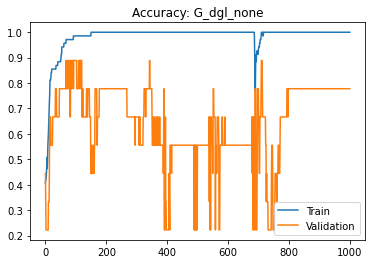

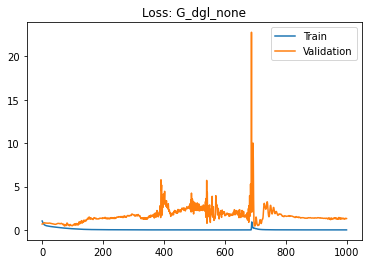

G_dgl_none 73 0.2204 0.9710 0.9706 0.4676 0.8889 0.8957
G_dgl_cca


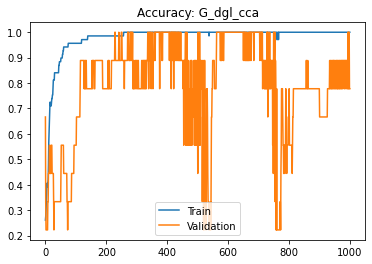

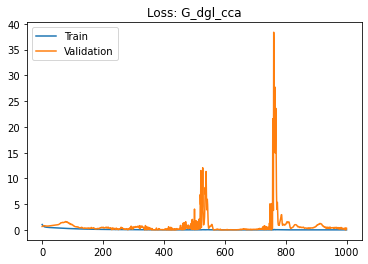

G_dgl_cca 588 0.0212 1.0000 1.0000 0.0110 1.0000 1.0000
G_dgl_pls


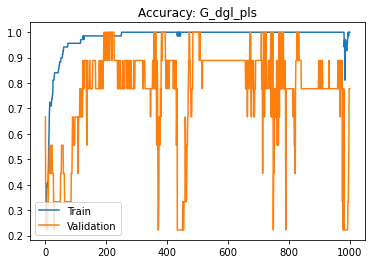

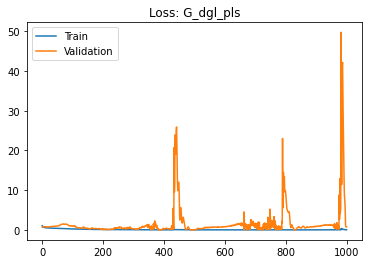

G_dgl_pls 721 0.0215 1.0000 1.0000 0.0080 1.0000 1.0000
G_dgl_pearson


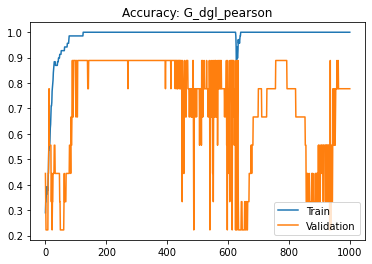

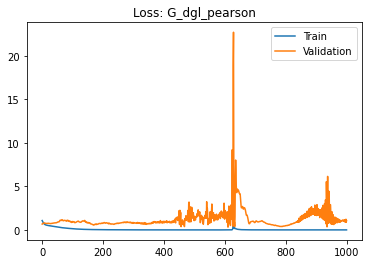

G_dgl_pearson 610 0.0136 1.0000 1.0000 0.3324 0.8889 0.8957
G_dgl_cca_neg


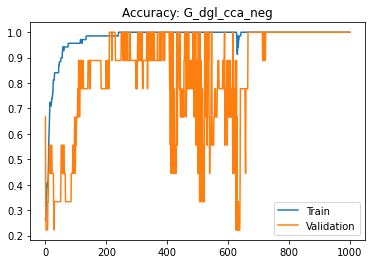

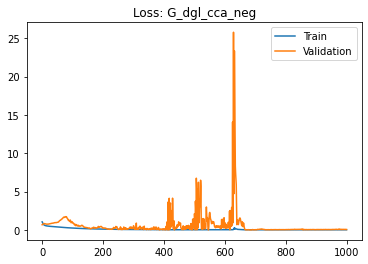

G_dgl_cca_neg 686 0.0241 1.0000 1.0000 0.0062 1.0000 1.0000
G_dgl_pls_neg


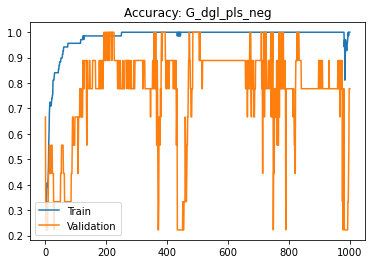

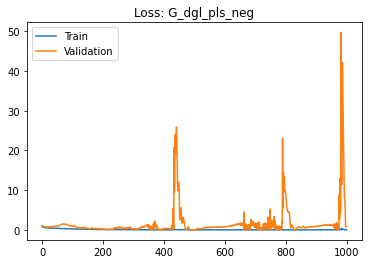

G_dgl_pls_neg 721 0.0215 1.0000 1.0000 0.0080 1.0000 1.0000
G_dgl_pearson_neg


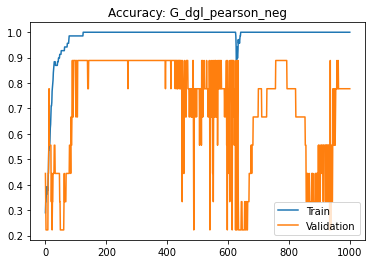

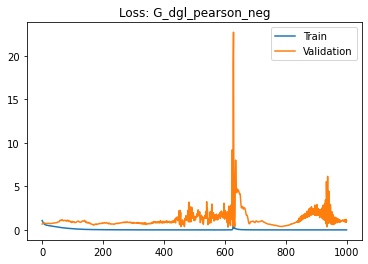

G_dgl_pearson_neg 610 0.0136 1.0000 1.0000 0.3324 0.8889 0.8957
G_dgl_gini


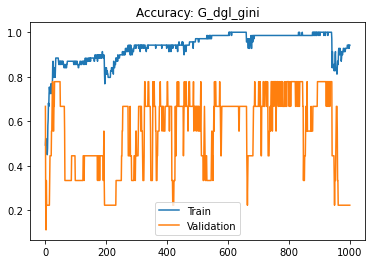

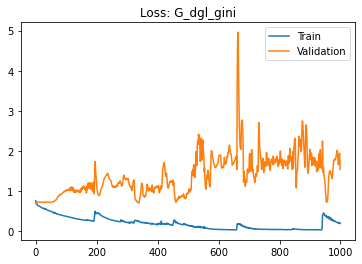

G_dgl_gini 0 0.7623 0.4928 0.4895 0.6905 0.6667 0.6926
G_dgl_shannon


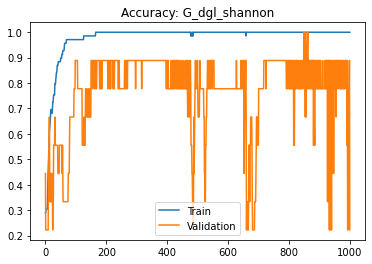

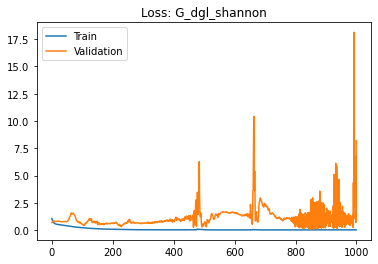

G_dgl_shannon 849 0.0154 1.0000 1.0000 0.0819 1.0000 1.0000
G_dgl_renyi


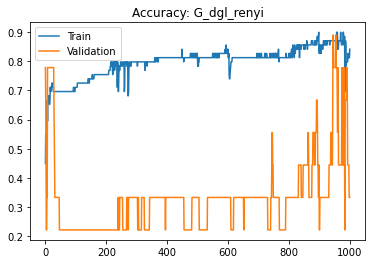

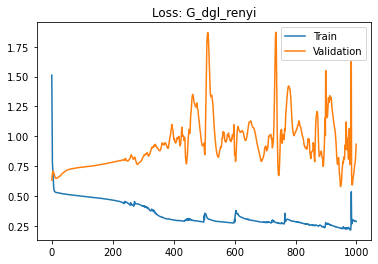

G_dgl_renyi 948 0.2330 0.8696 0.8733 0.5800 0.7778 0.7778
G_dgl_tsallis


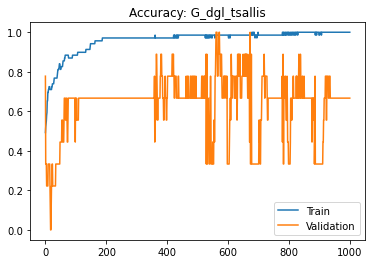

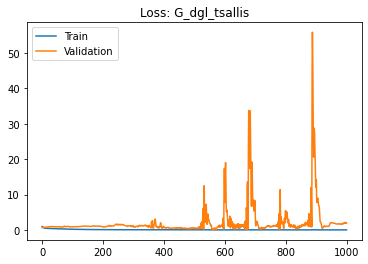

G_dgl_tsallis 562 0.0541 0.9855 0.9856 0.0377 1.0000 1.0000
G_dgl_mutualInfo


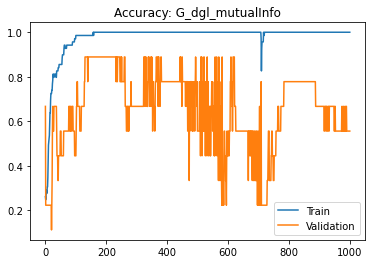

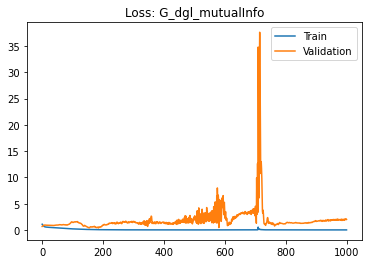

G_dgl_mutualInfo 184 0.0646 1.0000 1.0000 0.3914 0.8889 0.8957
G_dgl_kl


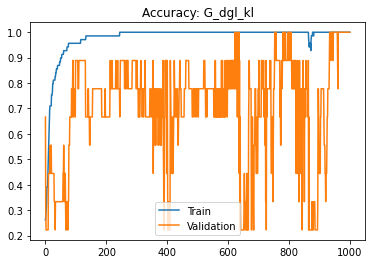

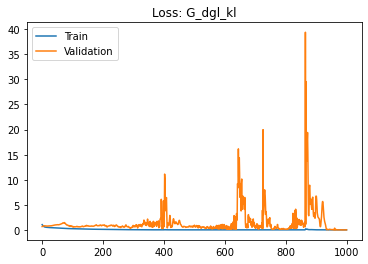

G_dgl_kl 972 0.0212 1.0000 1.0000 0.0106 1.0000 1.0000
G_dgl_js


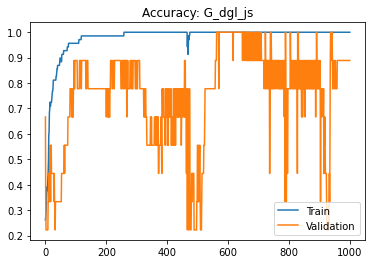

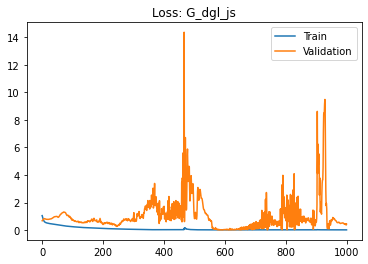

G_dgl_js 589 0.0214 1.0000 1.0000 0.0169 1.0000 1.0000


In [105]:

input_shape = all_data.iloc[:, 2:].shape[1]
hidden_size = 30
learning_rate = 0.0010

all_logits = []
for g_name,g in variable_map.items():
    torch.manual_seed(42)
    net = GCN(input_shape, hidden_size, 2, weight=torch.double)
    g = dgl.add_self_loop(g)

    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate,weight_decay=0.01) #weight_Decay: l2 penalty
    f1 = F1Score(task="multiclass", num_classes=2, average="weighted")
    n_epochs = 1000
    probability_train=[]
    probability_val=[]
    probability_test=[]
    prediction_train=[]
    prediction_val=[]
    prediction_test=[]
    train_acc=[]
    train_loss=[]
    train_f1=[]
    val_loss=[]
    val_acc=[]
    val_f1=[]
    score=[]
    for epoch in range(n_epochs):
        net.train()
        g_train=g.subgraph(train_indices)
        g_train.ndata['label']=node_labels[train_indices]
        if 'weight' in g_train.edata.keys():
            edge_weight = g_train.edata['weight'].double().float()
        else:
            edge_weight = None

        logits_train = net(g_train, g_train.ndata['feat'].double().float(),edge_weight=edge_weight)
        # save the logits for visualization later
        logp_train = F.log_softmax(logits_train, 1)
        probs_train=torch.exp(logp_train)
        prob_train,predicted_train=torch.max(probs_train, 1)
        probability_train.append(prob_train)
        prediction_train.append(predicted_train)
        loss=F.nll_loss(logp_train, node_labels[train_indices].type(torch.LongTensor),weight=torch.tensor([0.045,0.021])) 
        train_loss.append(loss)
        correct = (predicted_train == node_labels[train_indices]).sum().item()
        accuracy = correct / len(train_indices)
        train_acc.append(accuracy)
        f1_score=f1(predicted_train,node_labels[train_indices])
        train_f1.append(f1_score)

        net.eval()
        g_val=g.subgraph(val_indices)
        if 'weight' in g_val.edata.keys():
            edge_weight = g_val.edata['weight'].double().float()
        else:
            edge_weight = None
        logits_val = net(g_val, g_val.ndata['feat'].double().float(),edge_weight=edge_weight)
        logp_val = F.log_softmax(logits_val, 1)
        probs_val=torch.exp(logp_val)
        prob_val,predicted_val=torch.max(probs_val, 1)
        probability_val.append(prob_val)
        prediction_val.append(predicted_val)
        loss_val=F.nll_loss(logp_val, node_labels[val_indices].type(torch.LongTensor))
        val_loss.append(loss_val)
        val_correct = (predicted_val == node_labels[val_indices]).sum().item()
        val_accuracy = val_correct / len(val_indices)
        val_acc.append(val_accuracy)
        f1_score_val=f1(predicted_val,node_labels[val_indices])
        val_f1.append(f1_score_val)

        # test part
        g_test=g.subgraph(test_indices)
        if 'weight' in g_test.edata.keys():
            edge_weight = g_test.edata['weight'].double().float()
        else:
            edge_weight = None
        logits_test = net(g_test, g_test.ndata['feat'].double().float(),edge_weight=edge_weight)
        logp_test = F.log_softmax(logits_test, 1)
        probs_test=torch.exp(logp_test)
        prob_test,predicted_test=torch.max(probs_test, 1)
        probability_test.append(prob_test)
        prediction_test.append(predicted_test)
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()

    print(g_name)
    plt.plot(range(0, n_epochs), [acc for acc in train_acc], label="Train")
    plt.plot(range(0, n_epochs), [acc for acc in val_acc], label="Validation")
    plt.legend()
    plt.title(f"Accuracy: {g_name}")
    plt.show()

    plt.plot(range(0, n_epochs), [loss.item() for loss in train_loss], label="Train")
    plt.plot(range(0, n_epochs), [loss.item() for loss in val_loss], label="Validation")
    plt.legend()
    plt.title(f"Loss: {g_name}")
    plt.show()

    min_unl_loss = np.argmin([i.item() for i in val_loss])
    print(g_name,min_unl_loss,"%.4f" %train_loss[min_unl_loss].item(),"%.4f" %train_acc[min_unl_loss],
                       "%.4f" %train_f1[min_unl_loss].item(),"%.4f" %val_loss[min_unl_loss].item(),
                       "%.4f" %val_acc[min_unl_loss],"%.4f" %val_f1[min_unl_loss].item())
    
    predicted_labels=pd.DataFrame({'prediction':[i.item() for i in prediction_test[min_unl_loss]],'probability':[i.item() for i in probability_test[min_unl_loss]]}).set_index(test_indices)
    predicted_df=pd.merge(all_data, predicted_labels, left_index=True, right_index=True,
                               how="inner")[['GeneName','prediction','probability']]
    predicted_df['probability']=predicted_df['probability'].apply(lambda x: round(x, 2))
    pred_counts = predicted_df[predicted_df['probability']>0.95]['prediction'].value_counts()
    VPS13D=predicted_df[predicted_df['GeneName']=='VPS13D'][['prediction','probability']].values[0]    
    UFM1=predicted_df[predicted_df['GeneName']=='UFM1'][['prediction','probability']].values[0]
    C1QBP=predicted_df[predicted_df['GeneName']=='C1QBP'][['prediction','probability']].values[0]

    if 1 in pred_counts.index:
        patho_genes = pred_counts[1]
    else:
        patho_genes = 0
   
    all_logits.append([g_name,min_unl_loss,"%.4f" %train_loss[min_unl_loss].item(),"%.4f" %train_acc[min_unl_loss],
                       "%.4f" %train_f1[min_unl_loss].item(),"%.4f" %val_loss[min_unl_loss].item(),
                       "%.4f" %val_acc[min_unl_loss],"%.4f" %val_f1[min_unl_loss].item(),patho_genes,['pred:' + str("%.4f"%VPS13D[0]), 'prob:' + str(VPS13D[1])],
                      ['pred:' + str(UFM1[0]), 'prob:' + str("%.4f"%
                                                             UFM1[1])],['pred:' + str(C1QBP[0]), 'prob:' + str("%.4f"%C1QBP[1])]])
 

In [106]:
result_df=pd.DataFrame(all_logits,
                       columns=['weight method','epoch','train loss','train acc','train f1','val loss','val acc','val f1','prediction','VPS13D','UFM1','C1QBP'])

In [107]:
result_df['pred in %']=result_df['prediction']*100/1418
result_df['pred in %']=result_df['pred in %'].apply(lambda x: '{:.2f}'.format(x))

In [108]:
result_df.sort_values('prediction',ascending=False)

,weight method,epoch,train loss,train acc,train f1,val loss,val acc,val f1,prediction,VPS13D,UFM1,C1QBP,pred in %
9,G_dgl_renyi,948,0.2330,0.8696,0.8733,0.5800,0.7778,0.7778,1247,"[pred:1.0000, prob:1.0]","[pred:1.0, prob:1.0000]","[pred:1.0, prob:1.0000]",87.94
8,G_dgl_shannon,849,0.0154,1.0000,1.0000,0.0819,1.0000,1.0000,927,"[pred:1.0000, prob:0.89]","[pred:1.0, prob:1.0000]","[pred:1.0, prob:1.0000]",65.37
3,G_dgl_pearson,610,0.0136,1.0000,1.0000,0.3324,0.8889,0.8957,793,"[pred:0.0000, prob:0.77]","[pred:1.0, prob:1.0000]","[pred:1.0, prob:1.0000]",55.92
6,G_dgl_pearson_neg,610,0.0136,1.0000,1.0000,0.3324,0.8889,0.8957,735,"[pred:0.0000, prob:0.77]","[pred:1.0, prob:1.0000]","[pred:1.0, prob:1.0000]",51.83
12,G_dgl_kl,972,0.0212,1.0000,1.0000,0.0106,1.0000,1.0000,595,"[pred:1.0000, prob:0.97]","[pred:1.0, prob:0.9200]","[pred:1.0, prob:0.9800]",41.96
10,G_dgl_tsallis,562,0.0541,0.9855,0.9856,0.0377,1.0000,1.0000,461,"[pred:1.0000, prob:0.99]","[pred:1.0, prob:0.9600]","[pred:1.0, prob:0.9900]",32.51
2,G_dgl_pls,721,0.0215,1.0000,1.0000,0.0080,1.0000,1.0000,414,"[pred:1.0000, prob:1.0]","[pred:1.0, prob:0.9100]","[pred:1.0, prob:0.9300]",29.20
5,G_dgl_pls_neg,721,0.0215,1.0000,1.0000,0.0080,1.0000,1.0000,414,"[pred:1.0000, prob:1.0]","[pred:1.0, prob:0.9100]","[pred:1.0, prob:0.9300]",29.20
4,G_dgl_cca_neg,686,0.0241,1.0000,1.0000,0.0062,1.0000,1.0000,373,"[pred:1.0000, prob:0.99]","[pred:1.0, prob:0.7900]","[pred:1.0, prob:0.9200]",26.30
13,G_dgl_js,589,0.0214,1.0000,1.0000,0.0169,1.0000,1.0000,372,"[pred:1.0000, prob:0.91]","[pred:1.0, prob:0.8900]","[pred:1.0, prob:0.9400]",26.23


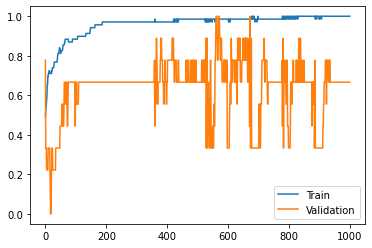

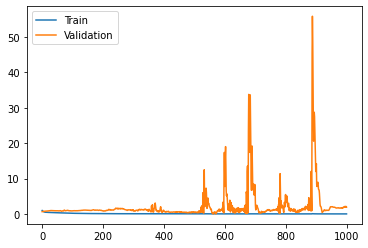

562 0.0541 0.9855 0.9856 0.0377 1.0000 1.0000


1    639
0    154
dtype: int64

In [109]:
## Final network with best edge weight and hyper-parameter

input_shape = all_data.iloc[:, 2:].shape[1]
hidden_size = 30
learning_rate = 0.0010
torch.manual_seed(42)

g=G_dgl_tsallis

net = GCN(input_shape, hidden_size, 2, weight=torch.double)
g = dgl.add_self_loop(g)

# save all evaluation metrics
all_logits = []

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate,weight_decay=0.01) #weight_Decay: l2 penalty
n_epochs = 1000
f1 = F1Score(task="multiclass", num_classes=2, average="weighted")

probability_train=[]
probability_val=[]
probability_test=[]
prediction_train=[]
prediction_val=[]
prediction_test=[]
train_acc=[]
train_loss=[]
train_f1=[]
val_acc=[]
val_loss=[]
val_f1=[]

for epoch in range(n_epochs):
    net.train()
    g_train=g.subgraph(train_indices)
    g_train.ndata['label']=node_labels[train_indices]
    if 'weight' in g_train.edata.keys():
        edge_weight = g_train.edata['weight'].double().float()
    else:
        edge_weight = None
    logits_train = net(g_train, g_train.ndata['feat'].double().float(),edge_weight=edge_weight)
    # save the logits for visualization later
    logp_train = F.log_softmax(logits_train, 1)
    probs_train=torch.exp(logp_train)
    prob_train,predicted_train=torch.max(probs_train, 1)
    probability_train.append(prob_train)
    prediction_train.append(predicted_train)
    loss=F.nll_loss(logp_train, node_labels[train_indices].type(torch.LongTensor),weight=torch.tensor([0.045,0.021]))
    train_loss.append(loss)
    correct = (predicted_train == node_labels[train_indices]).sum().item()
    accuracy = correct / len(train_indices)
    train_acc.append(accuracy)
    f1_score=f1(predicted_train,node_labels[train_indices])
    train_f1.append(f1_score)

    net.eval()
    g_val=g.subgraph(val_indices)
    if 'weight' in g_val.edata.keys():
        edge_weight = g_val.edata['weight'].double().float()
    else:
        edge_weight = None
    logits_val = net(g_val, g_val.ndata['feat'].double().float(),edge_weight=edge_weight)
    logp_val = F.log_softmax(logits_val, 1)
    probs_val=torch.exp(logp_val)
    prob_val,predicted_val=torch.max(probs_val, 1)
    probability_val.append(prob_val)
    prediction_val.append(predicted_val)
    loss_val=F.nll_loss(logp_val, node_labels[val_indices].type(torch.LongTensor))
    val_loss.append(loss_val)
    correct = (predicted_val == node_labels[val_indices]).sum().item()
    accuracy_val = correct / len(val_indices)
    val_acc.append(accuracy_val)
    f1_score_val=f1(predicted_val,node_labels[val_indices])
    val_f1.append(f1_score_val)

    g_test=g.subgraph(test_indices)
    if 'weight' in g_test.edata.keys():
        edge_weight = g_test.edata['weight'].double().float()
    else:
        edge_weight = None
    logits_test = net(g_test, g_test.ndata['feat'].double().float(),edge_weight=edge_weight)
    logp_test = F.log_softmax(logits_test, 1)
    probs_test=torch.exp(logp_test)
    prob_test,predicted_test=torch.max(probs_test, 1)
    probability_test.append(prob_test)
    prediction_test.append(predicted_test)

    optimizer.zero_grad() 
    loss.backward()
    optimizer.step()
min_unl_loss = np.argmin([i.item() for i in val_loss])
plt.plot(range(0, n_epochs), [acc for acc in train_acc], label="Train")
plt.plot(range(0, n_epochs), [acc for acc in val_acc], label="Validation")
plt.legend()
plt.show()

plt.plot(range(0, n_epochs), [loss.item() for loss in train_loss], label="Train")
plt.plot(range(0, n_epochs), [loss.item() for loss in val_loss], label="Validation")
plt.legend()
plt.show()

min_unl_loss = np.argmin([i.item() for i in val_loss])


print(min_unl_loss,"%.4f" %train_loss[min_unl_loss].item(),"%.4f" %train_acc[min_unl_loss],
                   "%.4f" %train_f1[min_unl_loss].item(),"%.4f" %val_loss[min_unl_loss].item(),
                   "%.4f" %val_acc[min_unl_loss],"%.4f" %val_f1[min_unl_loss].item())


pred=[label for prob, label in zip(probability_test[min_unl_loss], prediction_test[min_unl_loss]) if prob > 0.9]
predicted_labels=pd.DataFrame({'prediction':[i.item() for i in prediction_test[min_unl_loss]],'probability':[i.item() for i in probability_test[min_unl_loss]]}).set_index(test_indices)
predicted_df=pd.merge(all_data, predicted_labels, left_index=True, right_index=True,
                           how="inner")[['GeneName','prediction','probability']]
pred_counts = pd.DataFrame(pred).value_counts()

if 1 in pred_counts.index:
    patho_genes = pred_counts[1]
else:
    patho_genes = 0

display(pd.DataFrame(pred).value_counts())




In [110]:
predicted_labels=pd.DataFrame({'prediction':[i.item() for i in prediction_test[min_unl_loss]],'probability':[i.item() for i in probability_test[min_unl_loss]]}).set_index(test_indices)
predicted_df=pd.merge(all_data, predicted_labels, left_index=True, right_index=True,
                           how="inner")[['GeneName','prediction','probability']]
patho_genes=len(predicted_df[(predicted_df['prediction']==1)&(predicted_df['probability']>0.9)])
predicted_df[predicted_df['GeneName']=='VPS13D']

,GeneName,prediction,probability
58,VPS13D,1,0.994117


In [111]:
predicted_df[predicted_df['GeneName']=='UFM1']

,GeneName,prediction,probability
455,UFM1,1,0.957044


In [112]:
predicted_df[predicted_df['GeneName']=='C1QBP']

,GeneName,prediction,probability
313,C1QBP,1,0.991997


In [113]:
pd.DataFrame(prediction_test[min_unl_loss]).value_counts()

1    1092
0     326
dtype: int64

In [114]:
pd.DataFrame(prediction_train[min_unl_loss]).value_counts()

1    46
0    23
dtype: int64

In [115]:
pd.DataFrame(prediction_val[min_unl_loss]).value_counts()

1    7
0    2
dtype: int64

In [116]:
predicted_labels_train=pd.DataFrame({'prediction':[i.item() for i in prediction_train[min_unl_loss]],'probability':[i.item() for i in probability_train[min_unl_loss]]}).set_index(train_indices)
predicted_df_train=pd.merge(all_data, predicted_labels_train, left_index=True, right_index=True,
                               how="inner")[['GeneName','prediction','probability','pathogenic']]
len(predicted_df_train)

69

In [117]:
predicted_labels_val=pd.DataFrame({'prediction':[i.item() for i in prediction_val[min_unl_loss]],'probability':[i.item() for i in probability_val[min_unl_loss]]}).set_index(val_indices)
predicted_df_val=pd.merge(all_data, predicted_labels_val, left_index=True, right_index=True,
                               how="inner")[['GeneName','prediction','probability','pathogenic']]
predicted_df_val[predicted_df_val['pathogenic']=='0']

,GeneName,prediction,probability,pathogenic
567,LANCL2,0,0.999832,0
1379,HOXC4,0,0.945456,0


In [118]:
predicted_labels=pd.DataFrame({'prediction':[i.item() for i in prediction_test[min_unl_loss]],'probability':[i.item() for i in probability_test[min_unl_loss]]}).set_index(test_indices)
predicted_df=pd.merge(all_data, predicted_labels, left_index=True, right_index=True,
                               how="inner")[['GeneName','prediction','probability']]
predicted_df

,GeneName,prediction,probability
0,SEMA3F,1,0.622910
1,LAP3,1,0.980847
2,SLC25A5,1,0.874636
3,HOXA11,1,0.915436
4,THSD7A,1,0.894255
...,...,...,...
1482,RASL10B,1,0.911958
1483,CBSL,1,0.996967
1484,HIST1H2AJ,1,0.915874
1485,DACH1,0,0.986292


In [119]:
predicted_df.dtypes

GeneName        object
prediction       int64
probability    float64
dtype: object

In [120]:
predicted_df['probability']=predicted_df['probability'].apply(lambda x: round(x, 2))
predicted_df

,GeneName,prediction,probability
0,SEMA3F,1,0.62
1,LAP3,1,0.98
2,SLC25A5,1,0.87
3,HOXA11,1,0.92
4,THSD7A,1,0.89
...,...,...,...
1482,RASL10B,1,0.91
1483,CBSL,1,1.00
1484,HIST1H2AJ,1,0.92
1485,DACH1,0,0.99


In [121]:
predicted_df[predicted_df['GeneName']=='UFM1']

,GeneName,prediction,probability
455,UFM1,1,0.96


In [122]:
predicted_df[predicted_df['GeneName']=='VPS13D']

,GeneName,prediction,probability
58,VPS13D,1,0.99


In [123]:
predicted_df[predicted_df['GeneName']=='C1QBP']

,GeneName,prediction,probability
313,C1QBP,1,0.99


In [124]:
mitocarta_gene=predicted_df[predicted_df['probability']>0.95]['GeneName'].values
len(df_brown[(df_brown['GeneName'].isin(mitocarta_gene))&(df_brown['Mitocarta']==True)])

23

In [125]:
preds_df=predicted_df[(predicted_df['probability']>0.95)&(predicted_df['prediction']==1)]
preds_df['probability'].value_counts(),len(preds_df)

(1.00    169
 0.99    105
 0.98     77
 0.97     69
 0.96     41
 Name: probability, dtype: int64,
 461)

In [126]:
len(df_brown[df_brown['Mitocarta']==True]),len(df_brown[df_brown['Mitocarta']==True])*100/len(df_brown)

(147, 6.142916840785625)

In [127]:
pd.DataFrame(mitocarta_gene).to_csv('brown_gene')

In [128]:
len(df_brown[(df_brown['pathogenic']=='1')&(df_brown['Mitocarta']==True)])

42

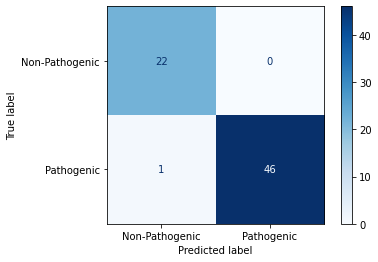

In [129]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, classification_report
cm=confusion_matrix(node_labels[train_indices],prediction_train[min_unl_loss])
disp = ConfusionMatrixDisplay(cm,display_labels=['Non-Pathogenic', 'Pathogenic']) #display_labels=['Class 0', 'Class 1']
disp.plot(cmap=plt.cm.Blues)

In [130]:
print(classification_report(node_labels[train_indices],prediction_train[min_unl_loss]))  #per class accuracy = recall

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        22
           1       1.00      0.98      0.99        47

    accuracy                           0.99        69
   macro avg       0.98      0.99      0.98        69
weighted avg       0.99      0.99      0.99        69



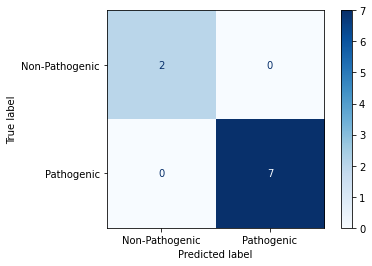

In [131]:
cm=confusion_matrix(node_labels[val_indices],prediction_val[min_unl_loss])
disp = ConfusionMatrixDisplay(cm,display_labels=['Non-Pathogenic', 'Pathogenic']) #display_labels=['Class 0', 'Class 1']
disp.plot(cmap=plt.cm.Blues)


In [132]:
print(classification_report(node_labels[val_indices],prediction_val[min_unl_loss]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         7

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9



#### Visualizing Network

In [133]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt

In [134]:
predicted_genes_all=pd.concat([predicted_df_train,predicted_df],axis=0).sort_index()
predicted_genes_all

,GeneName,prediction,probability,pathogenic
0,SEMA3F,1,0.62,NaN
1,LAP3,1,0.98,NaN
2,SLC25A5,1,0.87,NaN
3,HOXA11,1,0.92,NaN
4,THSD7A,1,0.89,NaN
...,...,...,...,...
1482,RASL10B,1,0.91,NaN
1483,CBSL,1,1.00,NaN
1484,HIST1H2AJ,1,0.92,NaN
1485,DACH1,0,0.99,NaN


In [135]:
predicted_genes_all.dtypes

GeneName        object
prediction       int64
probability    float64
pathogenic      object
dtype: object

In [136]:
# Identify the connected components
components = list(nx.connected_components(G_tsallis))

# Find the largest component (main set of network groups)
largest_component = max(components, key=len)

# Create a subgraph with only the nodes in the largest component
filtered_graph = G_tsallis.subgraph(largest_component)

In [137]:
required = [relabel_nodes[key] for v in ['UFM1','VPS13D','C1QBP'] for key in list(nx.ego_graph(G, v, radius=2).nodes()) if key in relabel_nodes]

For_G1=nx.subgraph(G_tsallis, required) #for all genes pass respective gene directly 

1


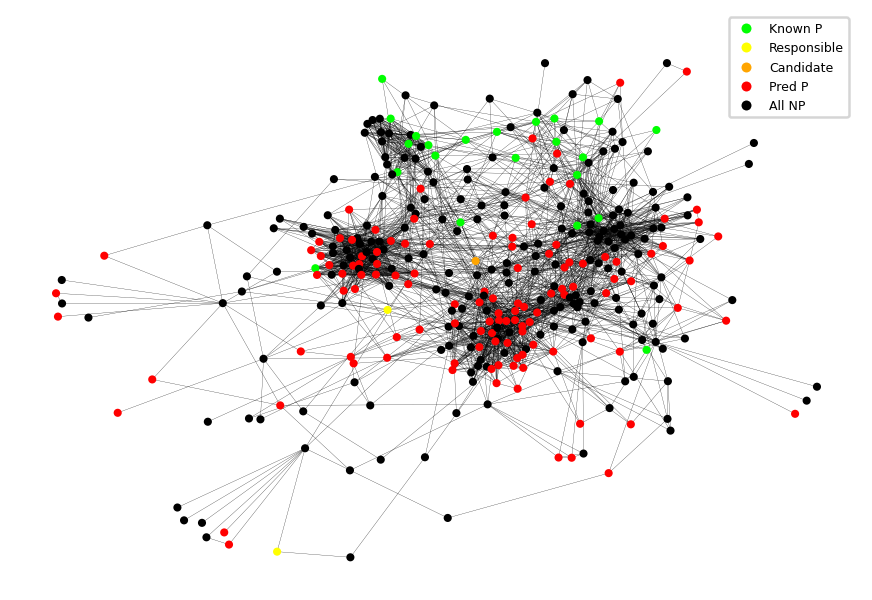

In [138]:
## network is shown for only responsible gene links with their neighboring nodes. For complete gene network, replace For_G1 graph
## with filtered_graph
def draw(frame):
    colors = []
    for v in For_G1.nodes:
        
        if predicted_genes_all['pathogenic'][v]=='1':
            colors.append("#00FF00")
        elif predicted_genes_all['pathogenic'][v]==0:
            colors.append("#000000")
        elif predicted_genes_all['prediction'][v]==1 and predicted_genes_all['GeneName'][v] in ['UFM1','VPS13D']:
            colors.append("#FFFF00")
        elif predicted_genes_all['prediction'][v]==1 and predicted_genes_all['GeneName'][v]== 'C1QBP':
            colors.append("#FFA500")
        elif predicted_genes_all['prediction'][v]==1 and predicted_genes_all['probability'][v]>0.95:
            colors.append("#FF0000")
        else:
            colors.append("#000000")
    ax.cla()
    ax.axis('off')
    p=nx.spring_layout(For_G1.to_undirected())
    nx.draw_networkx(For_G1.to_undirected(), p, node_color=colors,
            with_labels=False, node_size=5, ax=ax, width=0.1)
   # nx.draw_networkx_labels(G_draw.to_undirected(), p, labels=node_labels, font_size=6, font_color='black')
    legend_labels = {
        'Known P': "#00FF00",
        'Responsible':"#FFFF00",
        'Candidate':'#FFA500',
        'Pred P':"#FF0000",
        'All NP':"#000000"
    }
    
    # Display the legend
    for label, color in legend_labels.items():
        ax.plot([], [], marker='o', color='w', markerfacecolor=color, label=label, markersize=5)
    ax.legend(loc='upper right',fontsize=5,bbox_to_anchor=(1, 1.05))
    print(frame)

fig = plt.figure(dpi=180)
fig.clf()
ax = fig.subplots()
draw(1)

#### Animation ; takes lot of time

In [141]:
# import matplotlib
# matplotlib.rcParams['animation.embed_limit'] = 2**128
# matplotlib.rc('animation', html='jshtml')
# ani = animation.FuncAnimation(fig, draw, frames=len(filtered_graph.nodes), interval=500)
# ani

In [142]:
# ani.save('Gene_network_Brown.gif', writer='pillow')